In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score as sil_, calinski_harabasz_score as calinski_
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm
import re
from datetime import datetime, timezone
from sklearn.preprocessing import OneHotEncoder
import ipaddress
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from collections import Counter
import plotly.express as px

c:\Users\lucch\Desktop\thesis\thesis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Data Loading and Initial Preprocessing

In this section, we:
- Import required libraries
- Load the dataset
- Convert timestamps
- Check data quality

In [2]:
df = pd.read_csv('omnipot.csv')

In [3]:
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")

In [4]:
pd.concat([df.isna().sum().rename("missing values"), df.dtypes.rename("datatype"), df.nunique().rename("unique values")], axis=1)

missing values        datatype  unique values
src_port                      0           int64          61590
dst_port                      0           int64             33
timestamp                     0  datetime64[ns]         675827
src_as                     3149          object           6533
src_city                      5          object           8869
src_country                   0          object            199
src_countryCode              49          object            194
src_geo_str                   0          object          15357
src_ip                        0          object         112623
src_proxy                     0            bool              2
src_regionName              180          object           1674
dst_as                        0          object              1
dst_city                      0          object             40
dst_country                   0          object             18
dst_countryCode               0          object             18
dst_geo_str                   0          object             50
dst_ip                        0          object            408
dst_proxy                     0            bool              2
dst_regionName                0          object             34
protocol                      0          object             28
payload_4kb_hex          283736          object         137267

In [5]:
def get_ip_encoding(ipv4):
    oct1, oct2, oct3, oct4 = list(map(int, ipv4.split('.')))
    return {"oct1": oct1,
            "oct2": oct2,
            "oct3": oct3,
            "oct4": oct4}

df[['src_oct1', 'src_oct2', 'src_oct3', 'src_oct4']] = pd.DataFrame(df["src_ip"].apply(get_ip_encoding).values.tolist())
df[['dst_oct1', 'dst_oct2', 'dst_oct3', 'dst_oct4']] = pd.DataFrame(df["dst_ip"].apply(get_ip_encoding).values.tolist())

In [6]:
df["src_geo_str"] = df["src_geo_str"].str.split("|").apply(lambda lst: [float(x) for x in lst])
df["dst_geo_str"] = df["dst_geo_str"].str.split("|").apply(lambda lst: [float(x) for x in lst])

# 2. Geographic Feature Engineering

Processing geographical data:
- Convert coordinates to cartesian
- Calculate geographic distributions
- Process city and country information

In [7]:
def get_lat_lon(geo_list):
    lat = float(geo_list[1])
    lon = float(geo_list[0])
    
    lat_sin = np.sin(np.radians(lat))
    lat_cos = np.cos(np.radians(lat))
    lon_sin = np.sin(np.radians(lon))
    lon_cos = np.cos(np.radians(lon))

    return {"lat":lat, "lon":lon, "lat_sin": lat_sin, 'lat_cos' : lat_cos, "lon_sin": lon_sin, 'lon_cos' : lon_cos}

In [8]:
df[["src_lat","src_lon","src_lat_sin", "src_lat_cos", "src_lon_sin", "src_lon_cos"]] = pd.DataFrame(df["src_geo_str"].apply(get_lat_lon).values.tolist())
df[["dst_lat","dst_lon","dst_lat_sin", "dst_lat_cos", "dst_lon_sin", "dst_lon_cos"]] = pd.DataFrame(df["dst_geo_str"].apply(get_lat_lon).values.tolist())

df.drop(["src_geo_str", "dst_geo_str"], inplace=True, axis=1)

## average attack time and attacked time overall and per attacking country 

In [9]:
import folium

m = folium.Map(location=[20, 0], zoom_start=2)
n_to_show = 350  # adjust based on performance

# Sample to avoid overcrowding
sample = df[["src_lat", "src_lon", "src_ip", "dst_lat", "dst_lon", "dst_ip"]].dropna().sample(n=min(n_to_show, len(df)))

for row in sample.itertuples(index=False):
    lat, lon, ip, dlat, dlon, dip = row

    folium.CircleMarker(
        location=(lat, lon),
        radius=5, 
        color='red',
        fill=True,
        fill_color='purple',
        fill_opacity=0.7,
        popup=f"Source IP: {ip}"
    ).add_to(m)

    folium.PolyLine(
        locations=[(lat, lon), (dlat, dlon)],
        color='brown',
        weight=2,
        opacity=0.3
    ).add_to(m)

    folium.CircleMarker(
        location=(dlat, dlon),
        radius=6, 
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        popup=f"Destination IP: {dip}"
    ).add_to(m)
m

# 3. Time based attack analysis

In [10]:
import pytz
from timezonefinder import TimezoneFinder

tf = TimezoneFinder()

# Step 1: Ensure timestamp is timezone-aware (UTC)
if df["timestamp"].dt.tz is None:
    df["timestamp"] = df["timestamp"].dt.tz_localize("UTC")

# Step 2: Get timezones from lat/lon
def get_timezone(lat, lon):
    try:
        return tf.timezone_at(lat=lat, lng=lon)
    except:
        return None

df["src_timezone"] = df.apply(lambda row: get_timezone(row["src_lat"], row["src_lon"]), axis=1)
df["dst_timezone"] = df.apply(lambda row: get_timezone(row["dst_lat"], row["dst_lon"]), axis=1)

# Step 3: Convert to local time
def convert_to_local(row, tz_col):
    try:
        if pd.notnull(row[tz_col]):
            tz = pytz.timezone(row[tz_col])
            local_time = row["timestamp"].astimezone(tz)
            return local_time
    except:
        return pd.NaT

df["src_local_time"] = df.apply(lambda row: convert_to_local(row, "src_timezone"), axis=1)
df["dst_local_time"] = df.apply(lambda row: convert_to_local(row, "dst_timezone"), axis=1)

# Extract hour safely from timezone-aware timestamps
df["dst_local_hour"] = df["dst_local_time"].apply(lambda x: x.hour if pd.notnull(x) else np.nan)
df["src_local_hour"] = df["src_local_time"].apply(lambda x: x.hour if pd.notnull(x) else np.nan)

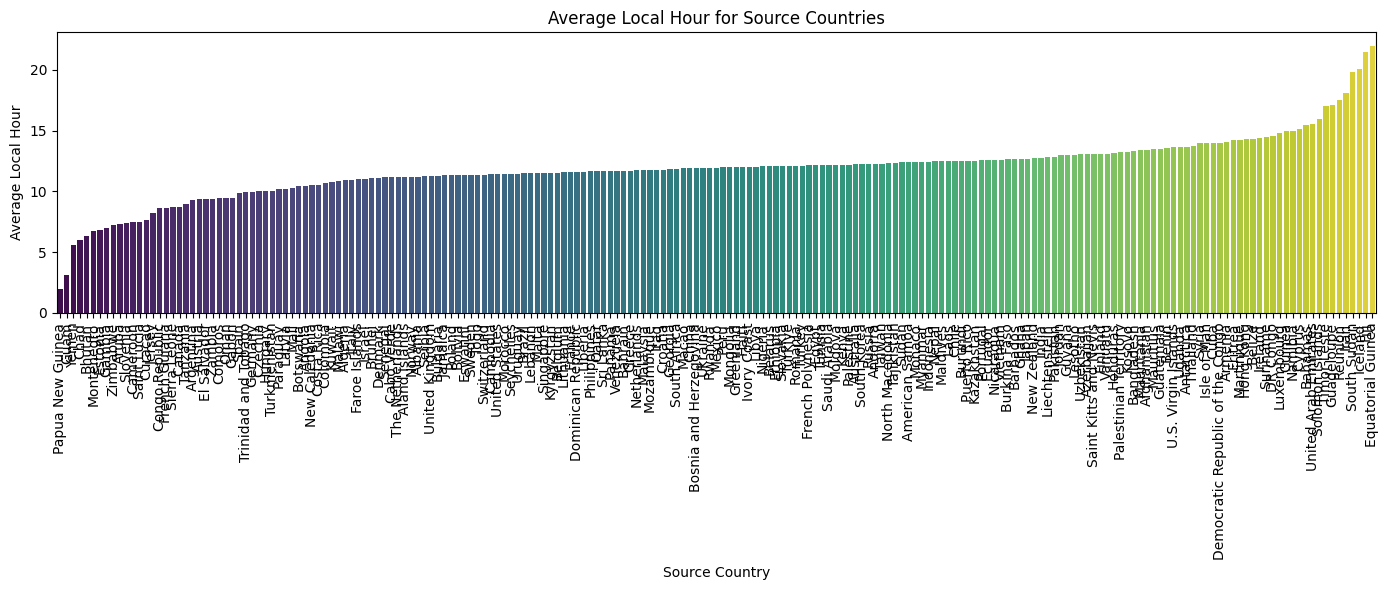

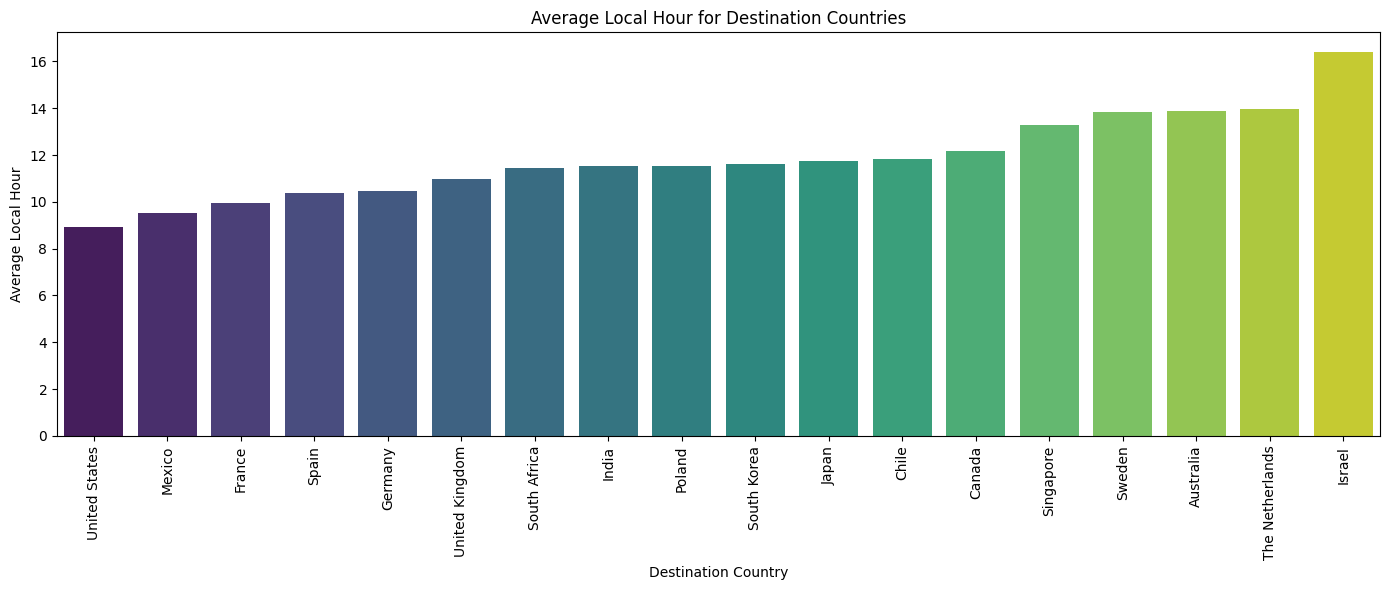

In [11]:
avg_src_by_country = df.groupby("src_country")["src_local_hour"].mean().sort_values()
avg_dst_by_country = df.groupby("dst_country")["dst_local_hour"].mean().sort_values()

plt.figure(figsize=(14, 6))
sns.barplot(x=avg_src_by_country.index, y=avg_src_by_country.values, hue=avg_src_by_country.index, palette="viridis", legend=False)
plt.xticks(rotation=90)
plt.title("Average Local Hour for Source Countries")
plt.xlabel("Source Country")
plt.ylabel("Average Local Hour")
plt.tight_layout()

plt.figure(figsize=(14, 6))
sns.barplot(x=avg_dst_by_country.index, y=avg_dst_by_country.values, hue=avg_dst_by_country.index, palette="viridis", legend=False)
plt.xticks(rotation=90)
plt.title("Average Local Hour for Destination Countries")
plt.xlabel("Destination Country")
plt.ylabel("Average Local Hour")
plt.tight_layout()

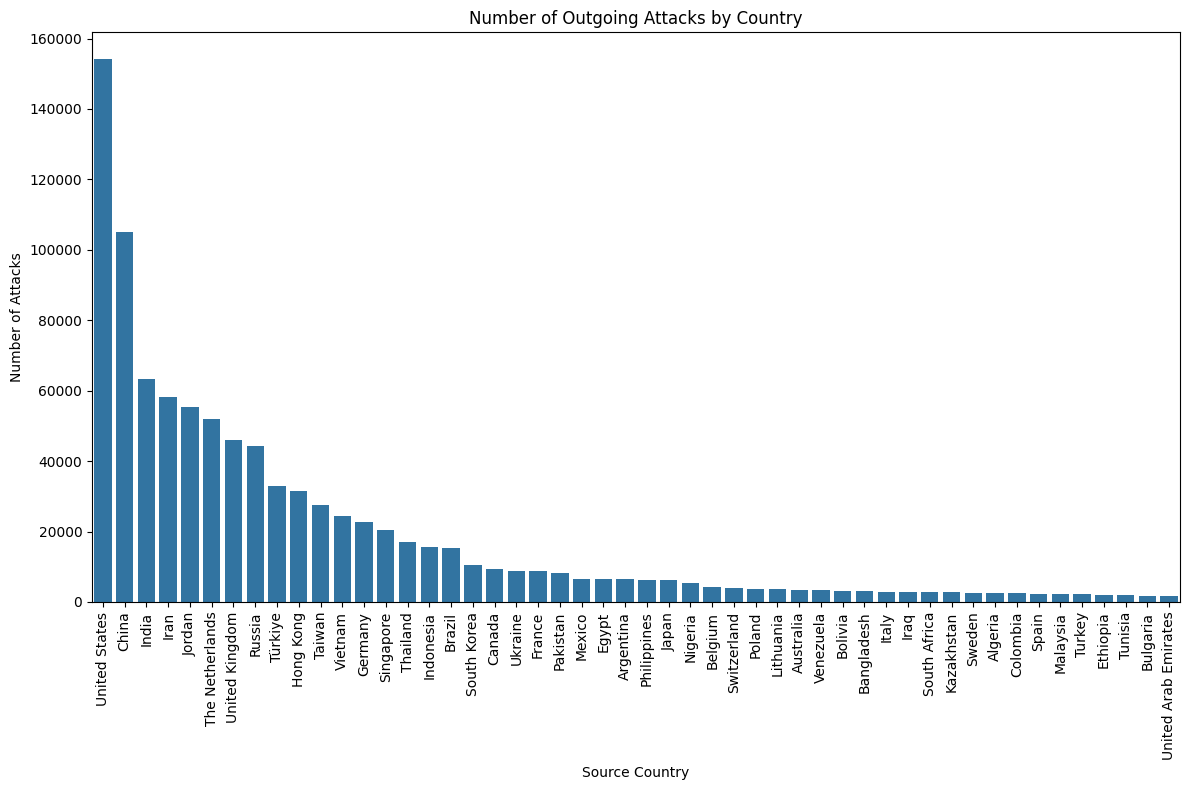

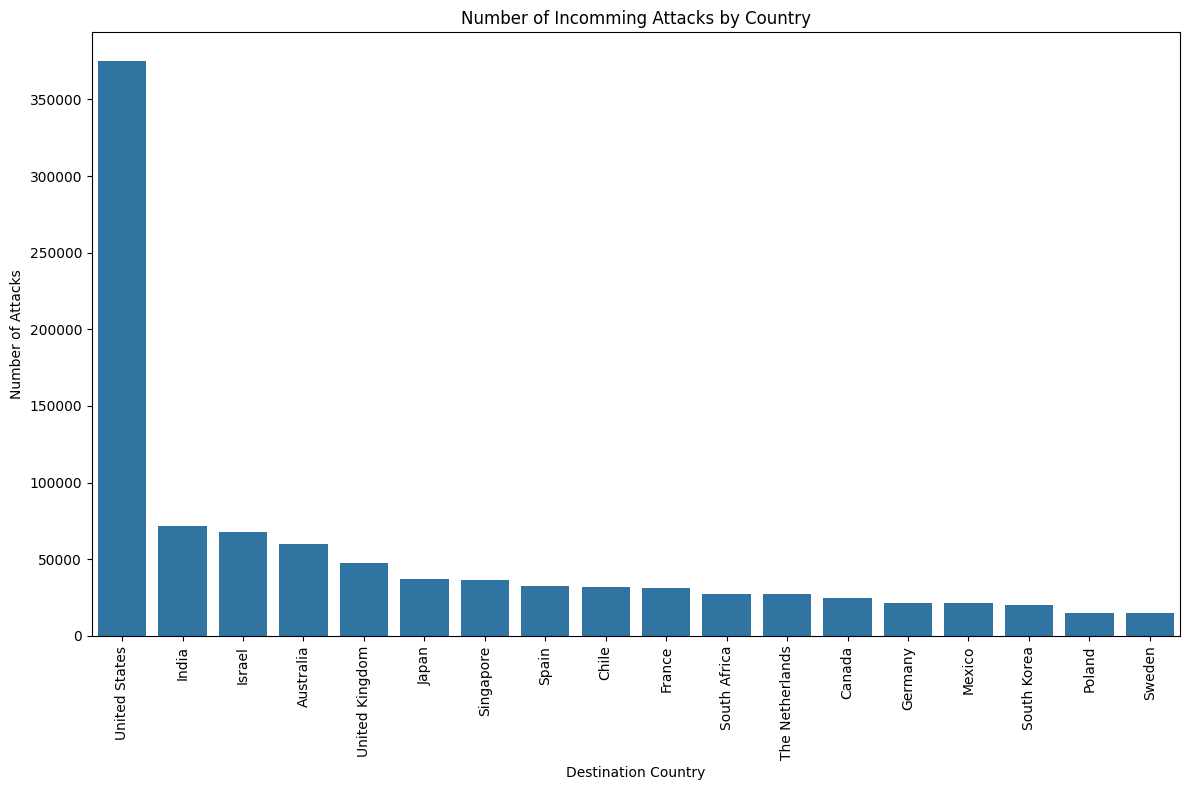

In [12]:
src_attack_counts = df["src_country"].value_counts().head(50)
dst_attack_counts = df["dst_country"].value_counts().head(50)

plt.figure(figsize=(12, 8))
sns.barplot(x=src_attack_counts.index, y=src_attack_counts.values)
plt.xticks(rotation=90)
plt.title("Number of Outgoing Attacks by Country")
plt.xlabel("Source Country")
plt.ylabel("Number of Attacks")
plt.tight_layout()


plt.figure(figsize=(12, 8))
sns.barplot(x=dst_attack_counts.index, y=dst_attack_counts.values)
plt.xticks(rotation=90)
plt.title("Number of Incomming Attacks by Country")
plt.xlabel("Destination Country")
plt.ylabel("Number of Attacks")
plt.tight_layout()
plt.show()

## 3.1 Temporal Feature engeneering

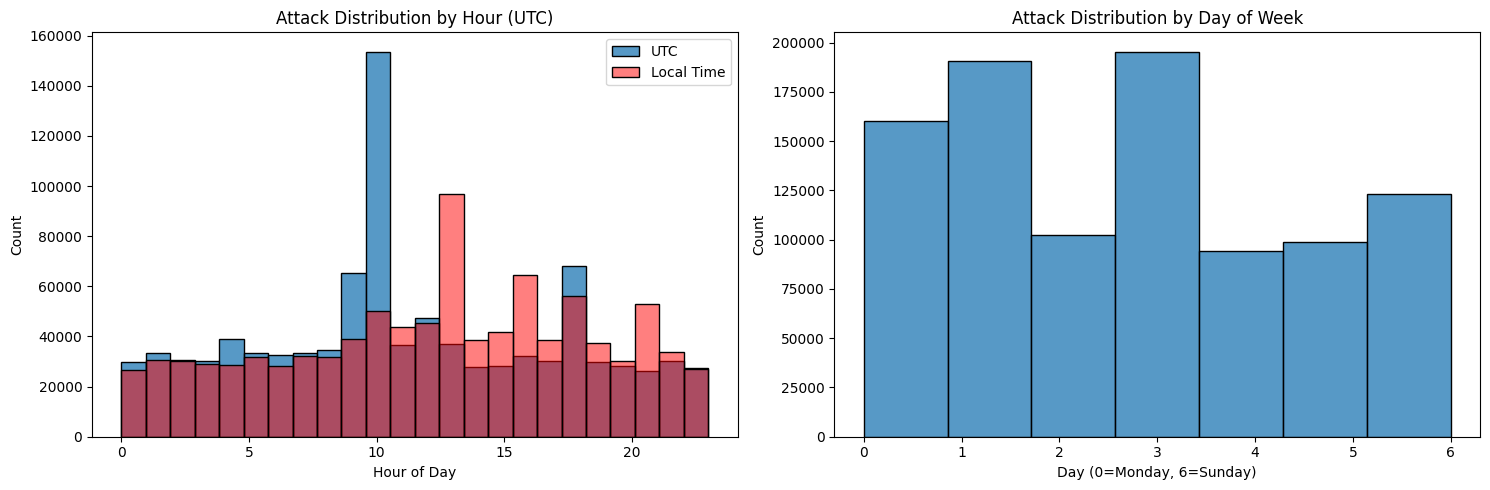

In [13]:
# Time-based features using timezone-aware timestamps
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['is_weekend'] = df['timestamp'].dt.dayofweek.isin([5,6]).astype(int)

# Plot attack frequency by hour and day
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Attacks by hour
sns.histplot(data=df, x='hour', bins=24, ax=ax1)
ax1.set_title('Attack Distribution by Hour (UTC)')
ax1.set_xlabel('Hour of Day')

# Also show local hour distribution
sns.histplot(data=df, x='src_local_hour', bins=24, ax=ax1, alpha=0.5, color='red', label='Local Time')
ax1.legend(['UTC', 'Local Time'])

# Attacks by day
sns.histplot(data=df, x='day_of_week', bins=7, ax=ax2)
ax2.set_title('Attack Distribution by Day of Week')
ax2.set_xlabel('Day (0=Monday, 6=Sunday)')
plt.tight_layout()

## 3.2 Inter-Attack Time Analysis
We analyze the time differences between consecutive attacks from the same source IP address. This helps identify:
- Automated attacks (very short, consistent intervals)
- Human-driven attacks (longer, more variable intervals)
- Batch processing patterns (regular peaks in activity)

Text(0, 0.5, 'Count (log scale)')

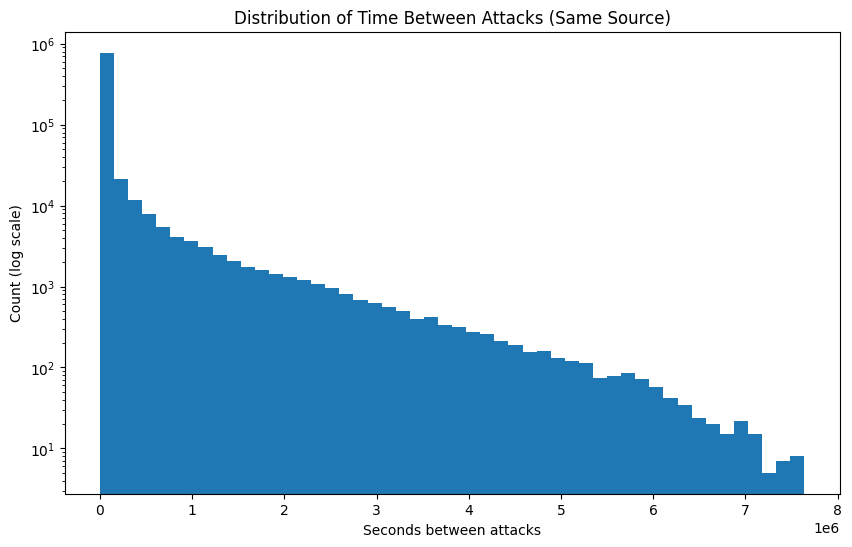

In [14]:
# Calculate time differences between attacks from same source
df_sorted = df.sort_values('timestamp')

# Ensure we're working with timezone-aware timestamps
df_sorted['time_diff'] = df_sorted.groupby('src_ip')['timestamp'].transform(lambda x: x.diff().dt.total_seconds())

# Plot time differences distribution
plt.figure(figsize=(10, 6))
plt.hist(df_sorted['time_diff'].dropna(), bins=50, log=True)
plt.title('Distribution of Time Between Attacks (Same Source)')
plt.xlabel('Seconds between attacks')
plt.ylabel('Count (log scale)')

In [15]:
# Classify time differences into categories
def classify_time_diff(seconds):
    if pd.isnull(seconds):
        return 'unknown'
    elif seconds < 1:
        return 'sub_second'
    elif seconds < 60:
        return '1-60sec'
    elif seconds < 3600:
        return '1-60min'
    elif seconds < 86400:
        return '1-24hr'
    else:
        return '>24hr'

df_sorted['time_category'] = df_sorted['time_diff'].apply(classify_time_diff)

C:\Users\lucch\AppData\Local\Temp\ipykernel_1792\1166020347.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')


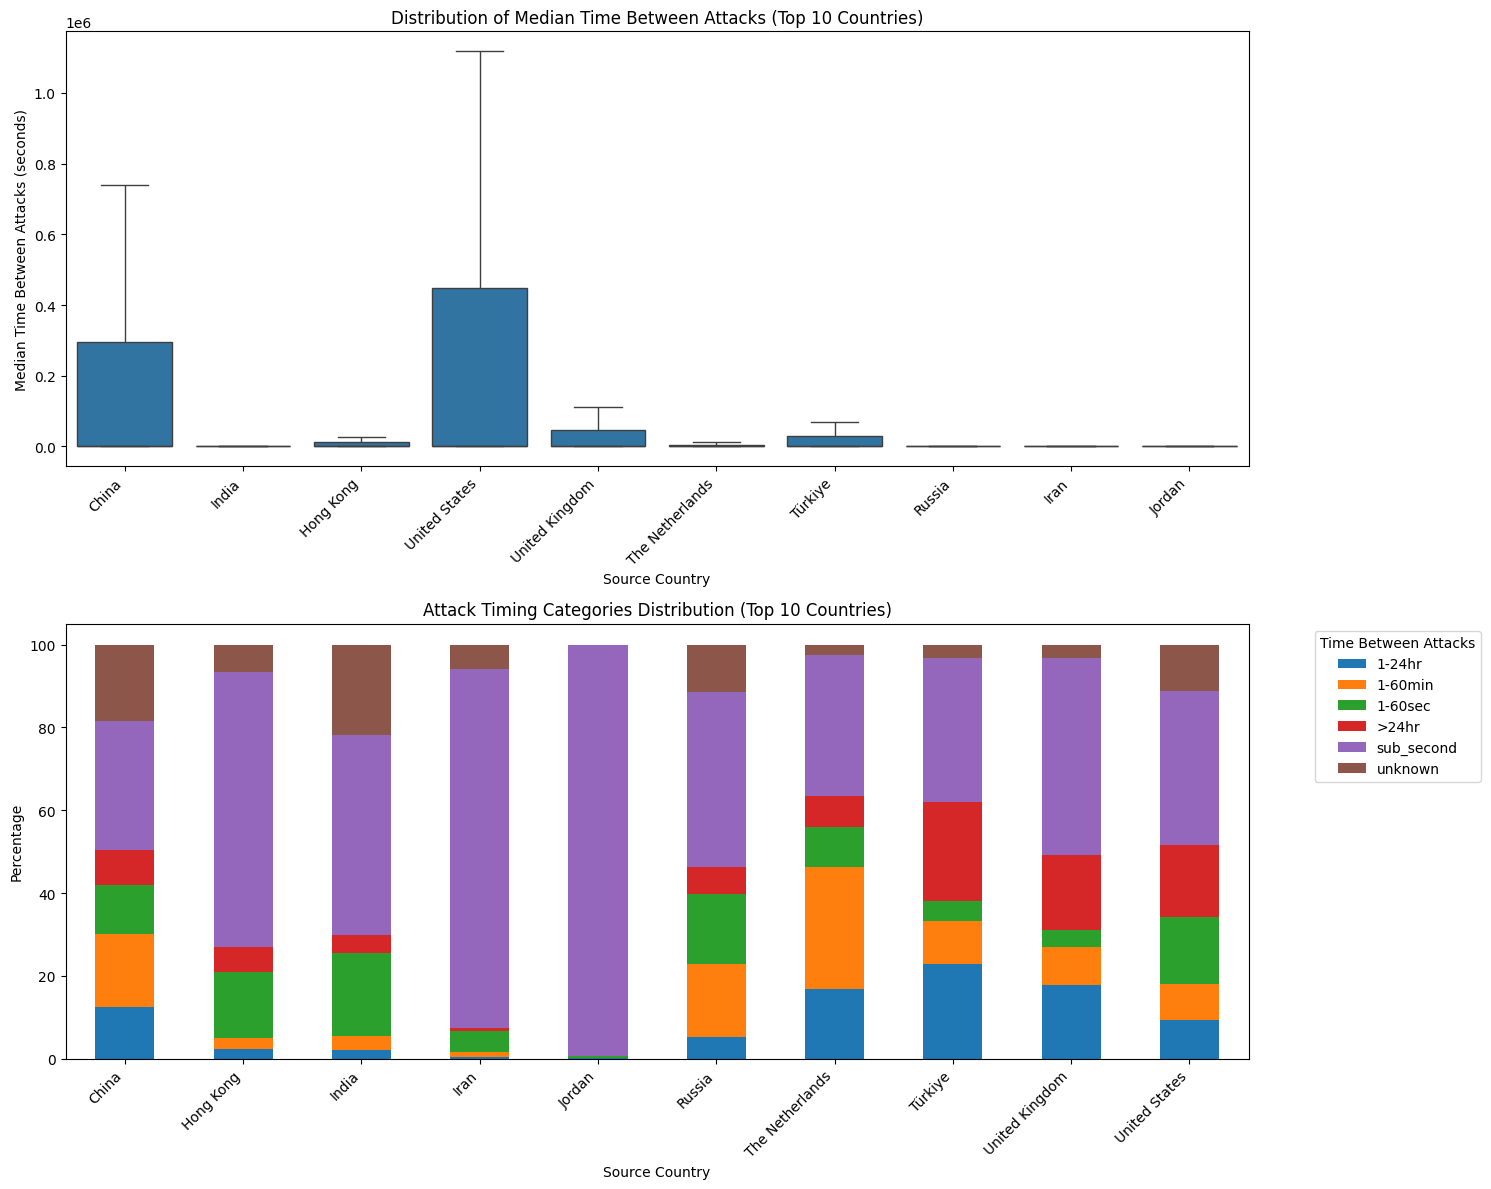


Summary Statistics for Top 10 Attacking Countries:
--------------------------------------------------

United States:
Total attacks: 154,068
Unique attackers: 17,203
Median time between attacks: 4.41 seconds
% of sub-second attacks: 37.2%

China:
Total attacks: 105,169
Unique attackers: 19,426
Median time between attacks: 13.02 seconds
% of sub-second attacks: 31.1%

India:
Total attacks: 63,435
Unique attackers: 13,860
Median time between attacks: 0.34 seconds
% of sub-second attacks: 48.2%

Iran:
Total attacks: 58,094
Unique attackers: 3,425
Median time between attacks: 0.00 seconds
% of sub-second attacks: 86.7%

Jordan:
Total attacks: 55,364
Unique attackers: 120
Median time between attacks: 0.00 seconds
% of sub-second attacks: 99.0%

The Netherlands:
Total attacks: 52,039
Unique attackers: 1,383
Median time between attacks: 193.76 seconds
% of sub-second attacks: 34.0%

United Kingdom:
Total attacks: 45,920
Unique attackers: 1,506
Median time between attacks: 2.77 seconds
% of s

In [17]:
# Get top 10 attacking countries
top_10_countries = df['src_country'].value_counts().head(10).index

# Filter data for top 10 countries
df_top10 = df_sorted[df_sorted['src_country'].isin(top_10_countries)]

# Calculate stats for top 10 countries
time_stats_top10 = df_top10.groupby(['src_ip', 'src_country'])['time_diff'].agg(['median', 'count']).reset_index()
country_stats_top10 = time_stats_top10.groupby('src_country').agg({
    'median': ['mean', 'std'],
    'count': 'sum'
}).reset_index()

# Create visualizations
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Box plot for top 10 countries
sns.boxplot(data=time_stats_top10, x='src_country', y='median', ax=ax1, showfliers=False)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_title('Distribution of Median Time Between Attacks (Top 10 Countries)')
ax1.set_xlabel('Source Country')
ax1.set_ylabel('Median Time Between Attacks (seconds)')

# Stacked bar plot for attack categories
time_categories_top10 = df_top10.groupby(['src_country', 'time_category']).size().unstack(fill_value=0)
time_categories_pct_top10 = time_categories_top10.div(time_categories_top10.sum(axis=1), axis=0) * 100
time_categories_pct_top10.plot(kind='bar', stacked=True, ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_title('Attack Timing Categories Distribution (Top 10 Countries)')
ax2.set_xlabel('Source Country')
ax2.set_ylabel('Percentage')
ax2.legend(title='Time Between Attacks', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics for Top 10 Attacking Countries:")
print("-" * 50)
for country in top_10_countries:
    country_data = df_top10[df_top10['src_country'] == country]
    print(f"\n{country}:")
    print(f"Total attacks: {len(country_data):,}")
    print(f"Unique attackers: {country_data['src_ip'].nunique():,}")
    print(f"Median time between attacks: {country_data['time_diff'].median():.2f} seconds")
    print(f"% of sub-second attacks: {(country_data['time_diff'] < 1).mean()*100:.1f}%")

### Sub-second (<1 second)

Attacks occurring less than 1 second apart
Usually indicates automated/bot attacks or DDoS attempts
Very high frequency, machine-generated traffic

### 1-60 seconds
Attacks occurring between 1-60 seconds apart
Often indicates automated scanning or systematic probing
Still too fast for human operation

### 1-60 minutes
Attacks occurring between 1-60 minutes apart
Could be both automated (with delays) or human-driven
May indicate more sophisticated scanning with rate limiting

### 1-24 hours
Attacks occurring between 1-24 hours apart
More likely to be human-driven or scheduled automated tasks
Could indicate daily routines or scheduled scans

### >24 hours
Attacks occurring more than 24 hours apart
Usually indicates sporadic attempts or long-term reconnaissance
More likely to be human-driven or opportunistic attacks

# 4. Port Scanning Behavior
Analyzed port scanning patterns by looking at:
- Sequential port access
- Port range coverage
- Standard deviation of port numbers

In [18]:
# Create port scanning features
def analyze_port_patterns(group):
    return {
        'sequential_ports': any(np.diff(sorted(group['dst_port'])) == 1),
        'port_range': group['dst_port'].max() - group['dst_port'].min(),
        'port_std': group['dst_port'].std()
    }

port_patterns = df.groupby('src_ip').apply(analyze_port_patterns).apply(pd.Series)
df = df.merge(port_patterns, left_on='src_ip', right_index=True, how='left')

C:\Users\lucch\AppData\Local\Temp\ipykernel_1792\1564377787.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  port_patterns = df.groupby('src_ip').apply(analyze_port_patterns).apply(pd.Series)


# 5. Statistical Features
Added entropy and geographic spread metrics to help identify:
- Randomness in port selection
- Target distribution patterns
- Automated vs. human behavior patterns

In [19]:
# Calculate attack entropy
df['attack_entropy'] = df.groupby('src_ip')['dst_port'].transform(lambda x: -sum([(v/len(x)) * np.log2(v/len(x)) 
                                                                                  for v in x.value_counts(normalize=True)]))

# Add more geographic features
df['target_country_diversity'] = df.groupby('src_ip')['dst_country'].transform('nunique')
df['target_city_diversity'] = df.groupby('src_ip')['dst_city'].transform('nunique')

# Calculate attack concentration by country
df['country_attack_concentration'] = df.groupby(['src_ip', 'dst_country']).cumcount() / \
                                    df.groupby('src_ip')['dst_country'].transform('count')

# Print feature statistics
print("\nGeographic Feature Statistics:")
print(df[['target_country_diversity', 'target_city_diversity', 
         'country_attack_concentration']].describe())


Geographic Feature Statistics:
       target_country_diversity  target_city_diversity  \
count             965090.000000          965090.000000   
mean                   5.697904               8.909154   
std                    5.855109              10.803467   
min                    1.000000               1.000000   
25%                    1.000000               1.000000   
50%                    3.000000               3.000000   
75%                    8.000000              12.000000   
max                   18.000000              39.000000   

       country_attack_concentration  
count                 965090.000000  
mean                       0.266610  
std                        0.280262  
min                        0.000000  
25%                        0.019384  
50%                        0.166667  
75%                        0.458613  
max                        0.999719  


# Protocol-Level Analysis and Attack Patterns

This section analyzes protocol-specific patterns in attacks to identify:
- Protocol-specific vulnerabilities
- Common attack vectors
- Service targeting patterns

In [20]:
protocol_categories = {
    'web': ['http', 'https'],
    'file_transfer': ['ftp', 'smb'],
    'remote_access': ['ssh', 'telnet', 'rdp', 'vnc', 'teamviewer', 'mikrotik'],
    'email': ['smtp', 'smtps', 'imap', 'imaps', 'pop3', 'pop3s'],
    'database': ['redis', 'mongodb', 'memcached', 'elasticsearch'],
    'messaging': ['mqtt', 'mqtts', 'amqp', 'amqps'],
    'vpn': ['openvpn'],
    'iot': ['tr-069', 'hisilicon'],
    'other': ['other']
}

inv_protocol_categories = {el: k for k, lst in protocol_categories.items() for el in lst}

df["protocol_category"] = df["protocol"].apply(lambda x: inv_protocol_categories[x])

In [21]:
import numpy as np

# Functions
def calculate_burstiness(timestamps):
    if len(timestamps) < 2:
        return 0
    intervals = np.diff(timestamps)
    mean_interval = np.mean(intervals)
    std_interval = np.std(intervals)
    return (std_interval / mean_interval) if mean_interval > 0 else 0

def calculate_periodicity(timestamps):
    if len(timestamps) < 2:
        return 0
    intervals = np.diff(timestamps)
    return (np.std(intervals) < 1e-3) * 1  # 1 = very periodic, 0 = not

# Group and calculate metrics
attack_metrics = []

for ip, group in df.groupby('src_ip'):
    times = group['timestamp'].sort_values().astype(np.int64) / 1e9  # convert to seconds
    burstiness = calculate_burstiness(times)
    periodicity = calculate_periodicity(times)
    port_diversity = group['dst_port'].nunique()
    target_diversity = group['dst_ip'].nunique()

    attack_metrics.append({
        'src_ip': ip,
        'burstiness': burstiness,
        'periodicity': periodicity,
        'port_diversity': port_diversity,
        'target_diversity': target_diversity
    })

attack_patterns = pd.DataFrame(attack_metrics).set_index('src_ip')

periodic_ips = attack_patterns[attack_patterns['periodicity'] == 1]
print(f"Highly periodic attackers: {len(periodic_ips)}")
print(periodic_ips.head())


Highly periodic attackers: 15195
             burstiness  periodicity  port_diversity  target_diversity
src_ip                                                                
1.0.104.204         0.0            1               1                 2
1.0.218.2           0.0            1               1                 1
1.0.218.22          0.0            1               1                 1
1.0.254.128         0.0            1               1                 1
1.10.223.3          0.0            1               1                 2


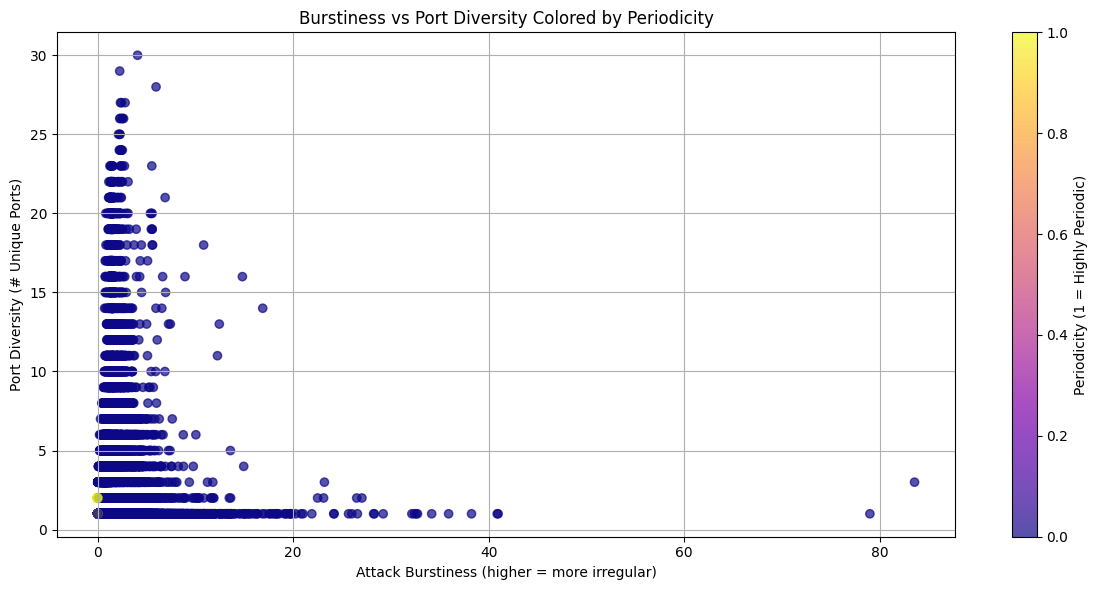

In [22]:
plt.figure(figsize=(12, 6))
sc = plt.scatter(
    attack_patterns['burstiness'],
    attack_patterns['port_diversity'],
    c=attack_patterns['periodicity'],
    cmap='plasma', alpha=0.7
)

plt.colorbar(sc, label='Periodicity (1 = Highly Periodic)')
plt.xlabel('Attack Burstiness (higher = more irregular)')
plt.ylabel('Port Diversity (# Unique Ports)')
plt.title('Burstiness vs Port Diversity Colored by Periodicity')
plt.grid(True)
plt.tight_layout()
plt.show()


# Entropy and N-gram Analysis

This section analyzes payload entropy and n-gram patterns to identify:
- Potential command injection attacks
- Encoded/encrypted payloads
- Common attack signatures

In [23]:
from scipy.stats import entropy
def get_payload_features(payload):
    default = {'length': 0, 'unique_bytes': 0, 'entropy': 0.0,
                'mean_byte': 0.0, 'std_byte': 0.0}
    if type(payload) is not str:
        return default

    data = bytes.fromhex(payload)
    length = len(data)
    if length == 0:
        return default

    arr = np.frombuffer(data, dtype=np.uint8)
    counts = np.bincount(arr, minlength=256)
    probs = counts / length

    ent = entropy(probs, base=2)

    mean = float(arr.mean())
    std = float(arr.std())

    return {
        'length': length,
        'unique_bytes': int(np.count_nonzero(counts)),
        'entropy': float(ent),
        'mean_byte': mean,
        'std_byte': std
    }
payload_feats = ['pl_length', 'pl_unique_bytes', 'pl_entropy', 'pl_mean_byte', 'pl_std_byte']

df[payload_feats] = pd.DataFrame(df["payload_4kb_hex"].apply(get_payload_features).values.tolist())

df.drop(["payload_4kb_hex"], inplace=True, axis=1)


Payload Feature Summary Statistics:
                    count        mean         std  min  25%        50%  \
pl_length        965090.0  139.850370  268.981664  0.0  0.0  52.000000   
pl_unique_bytes  965090.0   28.744640   35.272705  0.0  0.0  22.000000   
pl_entropy       965090.0    2.801866    1.954897  0.0  0.0   3.630413   
pl_mean_byte     965090.0   50.515365   41.104629  0.0  0.0  56.358025   
pl_std_byte      965090.0   40.392608   33.075346  0.0  0.0  35.720213   

                        75%          max  
pl_length        147.000000  6996.000000  
pl_unique_bytes   43.000000   227.000000  
pl_entropy         4.415208     6.059452  
pl_mean_byte      69.440000   206.333333  
pl_std_byte       61.277293   101.904501  

Potential Payload Anomalies Detected: 311332

Details of Anomalies:
    pl_length  pl_unique_bytes  pl_entropy  pl_mean_byte  pl_std_byte  \
1           0                0         0.0           0.0          0.0   
4           0                0         0.0   

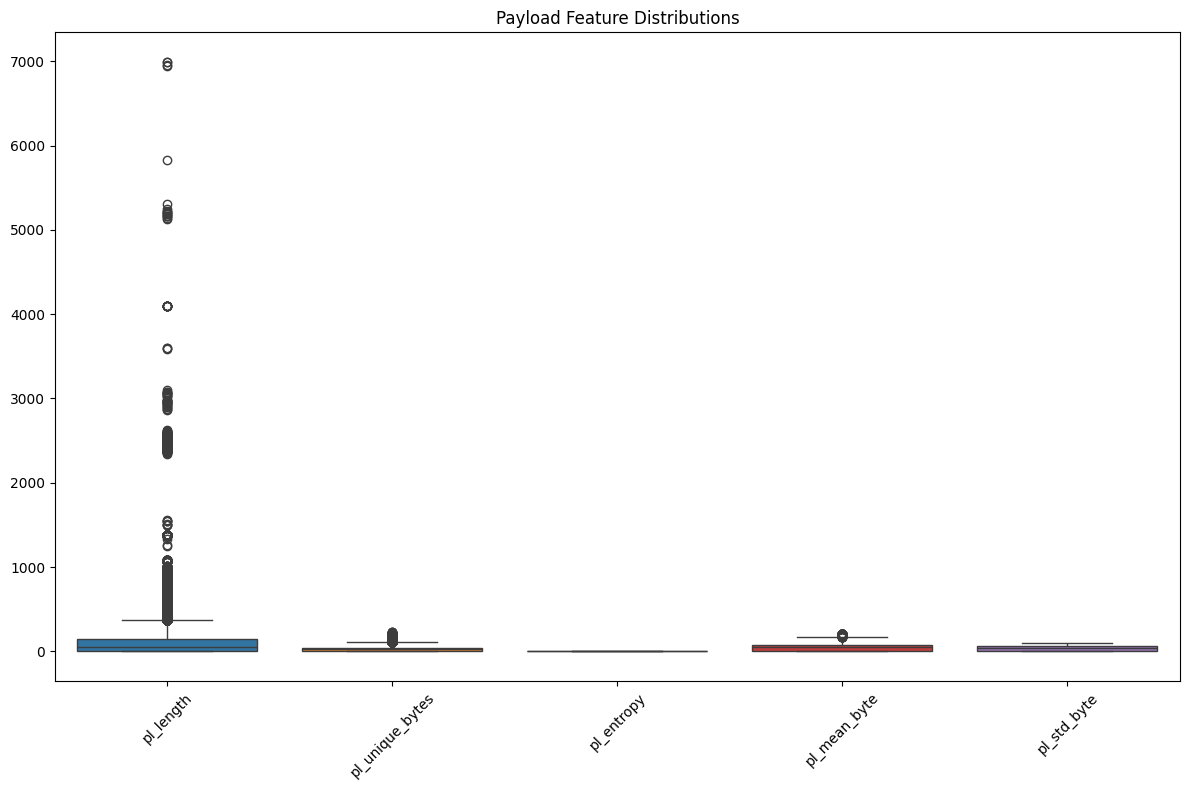

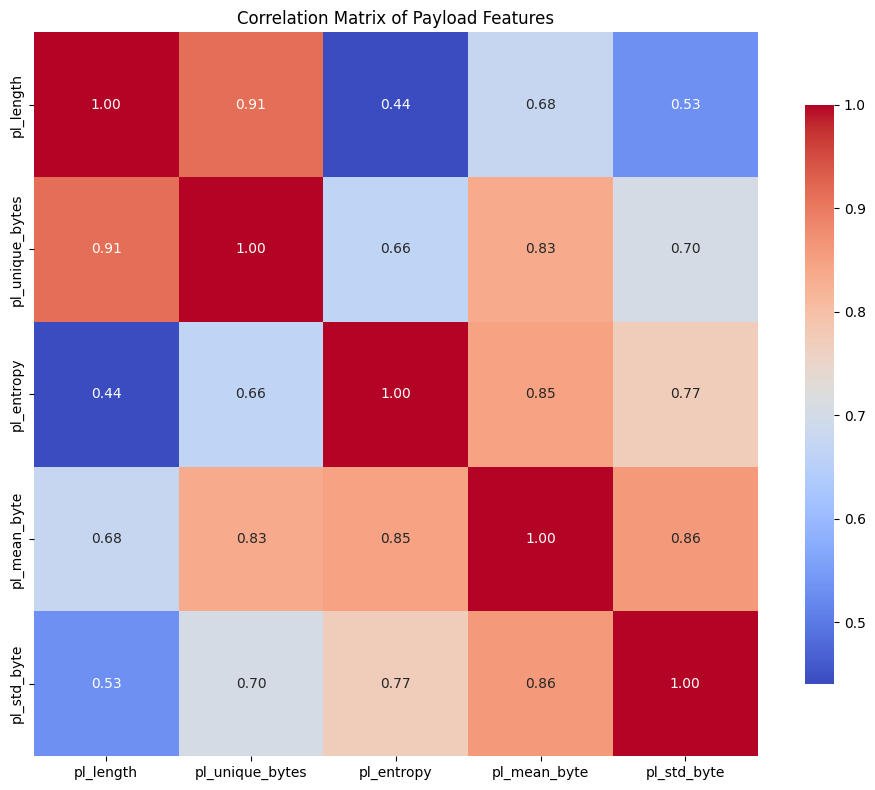

In [24]:
# analyse payload features
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[payload_feats])
plt.title('Payload Feature Distributions')
plt.xticks(rotation=45)
plt.tight_layout()

# Calculate correlation matrix for payload features
corr_matrix = df[payload_feats].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Payload Features')
plt.tight_layout()

# Print summary statistics for payload features
print("\nPayload Feature Summary Statistics:")
print(df[payload_feats].describe().T)

# Identify potential payload anomalies
anomalies = df[(df['pl_entropy'] < 2.0) | (df['pl_length'] > 4096)]
print(f"\nPotential Payload Anomalies Detected: {len(anomalies)}")

# Print details of anomalies
print("\nDetails of Anomalies:")
print(anomalies[payload_feats + ['src_ip', 'dst_ip', 'timestamp']].head(10))

In [25]:
df

src_port  dst_port                        timestamp  \
0          64787       445 2025-02-05 09:01:59.923000+00:00   
1          59105        23 2025-03-01 00:00:52.674000+00:00   
2          13652        22 2025-04-06 07:32:11.683000+00:00   
3          64010       445 2025-02-05 09:01:56.417000+00:00   
4          59105        23 2025-03-01 00:00:52.674000+00:00   
...          ...       ...                              ...   
965085     20720        23 2025-03-31 23:59:03.007000+00:00   
965086     20769        23 2025-03-31 23:59:16.029000+00:00   
965087     20811        23 2025-03-31 23:59:30.052000+00:00   
965088     54818        23 2025-03-31 23:59:33.627000+00:00   
965089     20871        23 2025-03-31 23:59:43.024000+00:00   

                                              src_as                src_city  \
0                                       AS8452 TE-AS              Alexandria   
1            AS4788 TM TECHNOLOGY SERVICES SDN. BHD.  Puchong Batu Dua Belas   
2                      AS6939 Hurricane Electric LLC                 Alameda   
3                                       AS8452 TE-AS              Alexandria   
4            AS4788 TM TECHNOLOGY SERVICES SDN. BHD.  Puchong Batu Dua Belas   
...                                              ...                     ...   
965085         AS4837 CHINA UNICOM China169 Backbone               Zhengzhou   
965086         AS4837 CHINA UNICOM China169 Backbone               Zhengzhou   
965087         AS4837 CHINA UNICOM China169 Backbone               Zhengzhou   
965088  AS140810 Megacore Technology Company Limited                   Hanoi   
965089         AS4837 CHINA UNICOM China169 Backbone               Zhengzhou   

          src_country src_countryCode           src_ip  src_proxy  \
0               Egypt              EG    102.43.79.235      False   
1            Malaysia              MY  175.143.203.217      False   
2       United States              US  184.105.247.252      False   
3               Egypt              EG    102.43.79.235      False   
4            Malaysia              MY  175.143.203.217      False   
...               ...             ...              ...        ...   
965085          China              CN   222.138.169.59      False   
965086          China              CN   222.138.169.59      False   
965087          China              CN   222.138.169.59      False   
965088        Vietnam              VN   103.77.246.172      False   
965089          China              CN   222.138.169.59      False   

       src_regionName  ... attack_entropy target_country_diversity  \
0          Alexandria  ...       0.352214                        1   
1            Selangor  ...       0.528321                        1   
2          California  ...       0.117448                       17   
3          Alexandria  ...       0.352214                        1   
4            Selangor  ...       0.528321                        1   
...               ...  ...            ...                      ...   
965085          Henan  ...       0.332193                        1   
965086          Henan  ...       0.332193                        1   
965087          Henan  ...       0.332193                        1   
965088          Hanoi  ...       0.126192                       12   
965089          Henan  ...       0.332193                        1   

       target_city_diversity country_attack_concentration protocol_category  \
0                          1                     0.000000     file_transfer   
1                          1                     0.000000     remote_access   
2                         26                     0.000000     remote_access   
3                          1                     0.111111     file_transfer   
4                          1                     0.333333     remote_access   
...                      ...                          ...               ...   
965085                     1                     0.600000     remot

# categories and pca of country/city

In [26]:
ohe = OneHotEncoder(drop='first', handle_unknown="ignore").fit(df[["protocol_category"]])

df[ohe.get_feature_names_out()] = ohe.transform(df[["protocol_category"]]).toarray().astype(int)
df.drop(columns=["protocol_category", "protocol"], inplace=True)

# Text Embedding and Dimension Reduction

Process textual data:
- City name embeddings
- PCA dimension reduction
- Feature matrix preparation

In [27]:
model = SentenceTransformer('all-MiniLM-L6-v2')
src_city_embeddings = model.encode(df['src_city'].astype(str).tolist())
dst_city_embeddings = model.encode(df['dst_city'].astype(str).tolist())
src_country_embeddings = model.encode(df['src_country'].astype(str).tolist())
dst_country_embeddings = model.encode(df['dst_country'].astype(str).tolist())

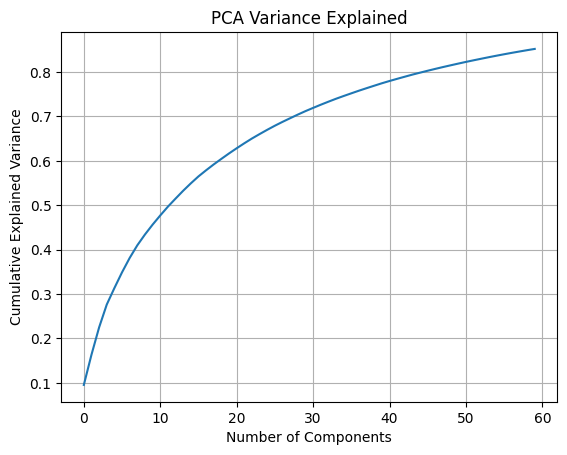

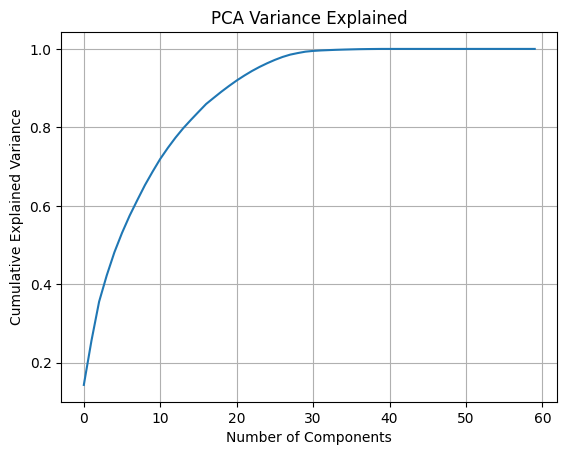

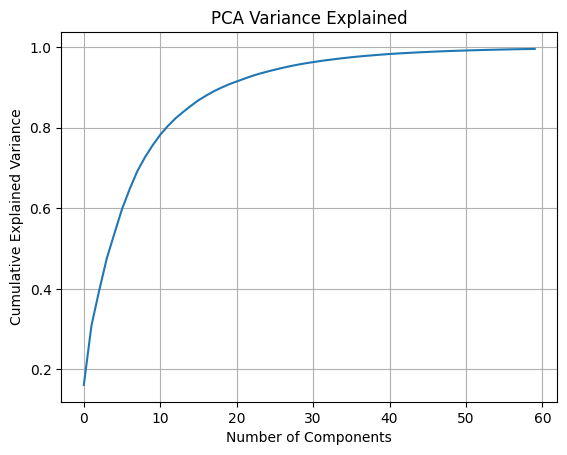

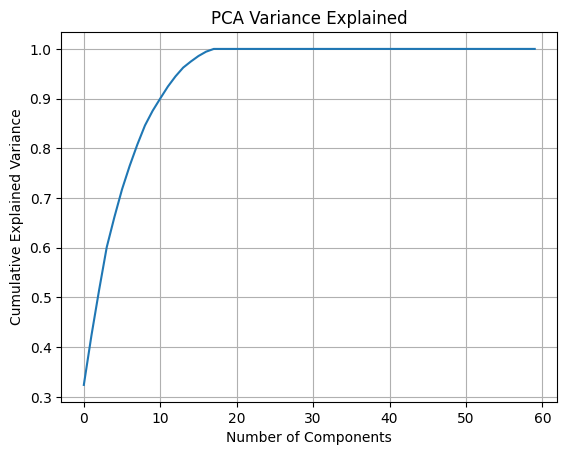

In [28]:
pca_full = PCA().fit(src_city_embeddings)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
plt.plot(cumulative_variance[:60])
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Variance Explained')
plt.grid(True)
plt.show()

pca_full = PCA().fit(dst_city_embeddings)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
plt.plot(cumulative_variance[:60])
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Variance Explained')
plt.grid(True)
plt.show()

pca_full = PCA().fit(src_country_embeddings)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
plt.plot(cumulative_variance[:60])
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Variance Explained')
plt.grid(True)
plt.show()

pca_full = PCA().fit(dst_country_embeddings)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
plt.plot(cumulative_variance[:60])
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Variance Explained')
plt.grid(True)
plt.show()

In [29]:
n_components = 26
pca = PCA(n_components=n_components)
src_city_emb_reduced = pca.fit_transform(src_city_embeddings)

explained_variance_ratio = pca.explained_variance_ratio_
total_variance = explained_variance_ratio.sum()

n_components = 19
pca = PCA(n_components=n_components)
dst_city_emb_reduced = pca.fit_transform(dst_city_embeddings)
explained_variance_ratio = pca.explained_variance_ratio_
total_variance = explained_variance_ratio.sum()

n_components = 19
pca = PCA(n_components=n_components)
src_country_emb_reduced = pca.fit_transform(src_country_embeddings)
explained_variance_ratio = pca.explained_variance_ratio_
total_variance = explained_variance_ratio.sum()

n_components = 10
pca = PCA(n_components=n_components)
dst_country_emb_reduced = pca.fit_transform(dst_country_embeddings)
explained_variance_ratio = pca.explained_variance_ratio_
total_variance = explained_variance_ratio.sum()

In [33]:
city_emb_cols = [f"src_city_emb_{i}" for i in range(src_city_emb_reduced.shape[1])]
city_emb_df = pd.DataFrame(src_city_emb_reduced, columns=city_emb_cols, index=df.index)
df = pd.concat([df, city_emb_df], axis=1)


city_emb_cols = [f"dst_city_emb_{i}" for i in range(dst_city_emb_reduced.shape[1])]
city_emb_df = pd.DataFrame(dst_city_emb_reduced, columns=city_emb_cols, index=df.index)
df = pd.concat([df, city_emb_df], axis=1)

country_emb_cols = [f"src_country_emb_{i}" for i in range(src_country_emb_reduced.shape[1])]
country_emb_df = pd.DataFrame(src_country_emb_reduced, columns=country_emb_cols, index=df.index)
df = pd.concat([df, country_emb_df], axis=1)

country_emb_cols = [f"dst_country_emb_{i}" for i in range(dst_country_emb_reduced.shape[1])]
country_emb_df = pd.DataFrame(dst_country_emb_reduced, columns=country_emb_cols, index=df.index)
df = pd.concat([df, country_emb_df], axis=1)

In [35]:
df.to_csv("omnipot_processed.csv", index=False)

# Categorical Feature Encoding

We'll encode our categorical features using appropriate techniques:
- One-hot encoding for nominal categories with few unique values
- Target encoding for high-cardinality features
- Frequency encoding for location-based features

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score as sil_, calinski_harabasz_score as calinski_
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm
import re
from datetime import datetime, timezone
from sklearn.preprocessing import OneHotEncoder
import ipaddress
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from collections import Counter
import plotly.express as px
from sklearn.utils import resample
import hdbscan
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer


c:\Users\lucch\Desktop\thesis\thesis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df = pd.read_csv('omnipot_processed.csv')
# df = resample(df, n_samples=200000)
df.reset_index(drop=True, inplace=True)


In [19]:
print(list(df.columns))

['src_port', 'dst_port', 'src_proxy', 'dst_proxy', 'src_oct1', 'src_oct2', 'src_oct3', 'src_oct4', 'dst_oct1', 'dst_oct2', 'dst_oct3', 'dst_oct4', 'src_lat', 'src_lon', 'src_lat_sin', 'src_lat_cos', 'src_lon_sin', 'src_lon_cos', 'dst_lat', 'dst_lon', 'dst_lat_sin', 'dst_lat_cos', 'dst_lon_sin', 'dst_lon_cos', 'hour', 'day_of_week', 'is_weekend', 'max_consecutive_similar', 'sequential_ports', 'port_range', 'port_std', 'attack_entropy', 'target_country_diversity', 'target_city_diversity', 'country_attack_concentration', 'pl_length', 'pl_unique_bytes', 'pl_entropy', 'pl_mean_byte', 'pl_std_byte', 'protocol_category_email', 'protocol_category_file_transfer', 'protocol_category_iot', 'protocol_category_messaging', 'protocol_category_other', 'protocol_category_remote_access', 'protocol_category_vpn', 'protocol_category_web', 'src_city_emb_0', 'src_city_emb_1', 'src_city_emb_2', 'src_city_emb_3', 'src_city_emb_4', 'src_city_emb_5', 'src_city_emb_6', 'src_city_emb_7', 'src_city_emb_8', 'src_ci

In [3]:
df.replace({True: 1, False: 0}, inplace=True)

C:\Users\lucch\AppData\Local\Temp\ipykernel_16352\3673826116.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0}, inplace=True)


In [4]:
num_unique_as = df['src_as'].nunique()
as_freq = df['src_as'].value_counts().to_dict()
df['src_as_encoded'] = df['src_as'].map(as_freq)
num_unique_as  

4240

In [5]:
as_freq = df['src_as'].value_counts().to_dict()
df['src_as_encoded'] = df['src_as'].map(as_freq)

In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed', errors='coerce')

df['minute'] = df['timestamp'].dt.minute
df["second"] = df['timestamp'].dt.second

In [7]:
df.drop(columns=["protocol_category", 'src_local_hour', 'dst_local_hour', "timestamp", "src_local_time", "dst_local_time", 'src_ip', 'dst_ip', "src_as", "dst_as", "src_city", "dst_city", "src_country", "dst_country", "src_timezone", "dst_timezone", "src_regionName", "dst_regionName", "src_countryCode", "dst_countryCode", "protocol"], inplace=True, errors='ignore')


Missing values after preprocessing:
Empty DataFrame
Columns: [missing_count]
Index: []


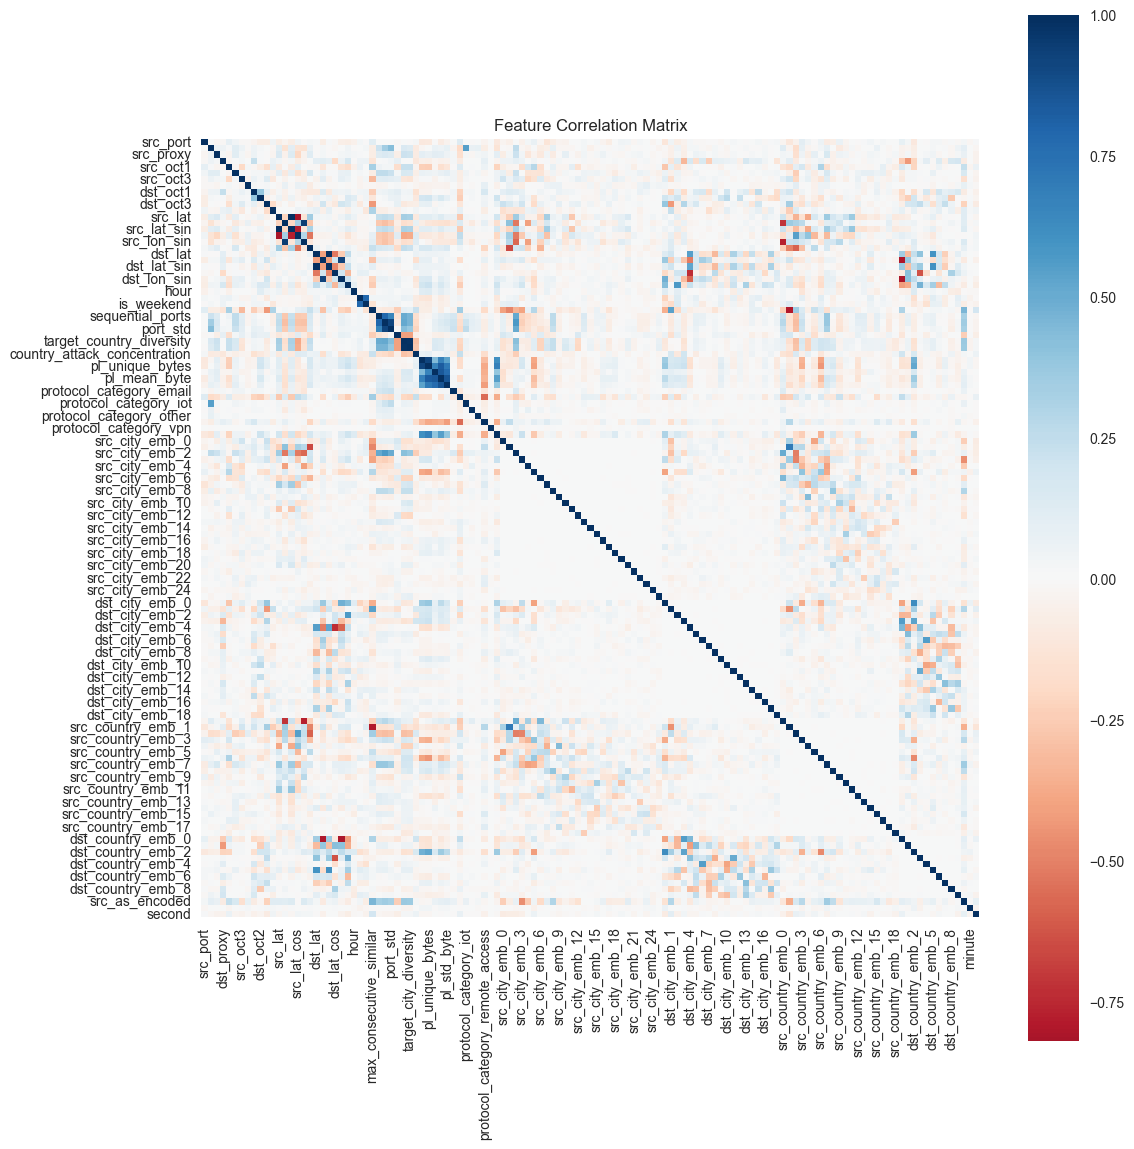

In [8]:
X = df.copy()

# Handle missing values with appropriate strategies
for col in X.columns:
    if X[col].dtype in ['int64', 'float64']:
        if 'ratio' in col:
            # For ratio features, fill with 0
            X[col] = X[col].fillna(0)
        else:
            # For other numeric features, fill with median
            X[col] = X[col].fillna(X[col].median())

# Standardize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Check for any remaining missing values
print('\nMissing values after preprocessing:')
print(pd.DataFrame({'missing_count': X.isna().sum()[X.isna().sum() > 0]}))

# Feature correlation analysis
plt.figure(figsize=(12, 12))
sns.heatmap(X.corr(), center=0, cmap='RdBu', square=True)
plt.title('Feature Correlation Matrix')
plt.tight_layout()

# 6. Advanced Attack Pattern Clustering

This section uses sophisticated clustering techniques to identify:
- Geographic attack patterns
- Temporal attack clusters
- Protocol behavior patterns
- Attack campaign fingerprints

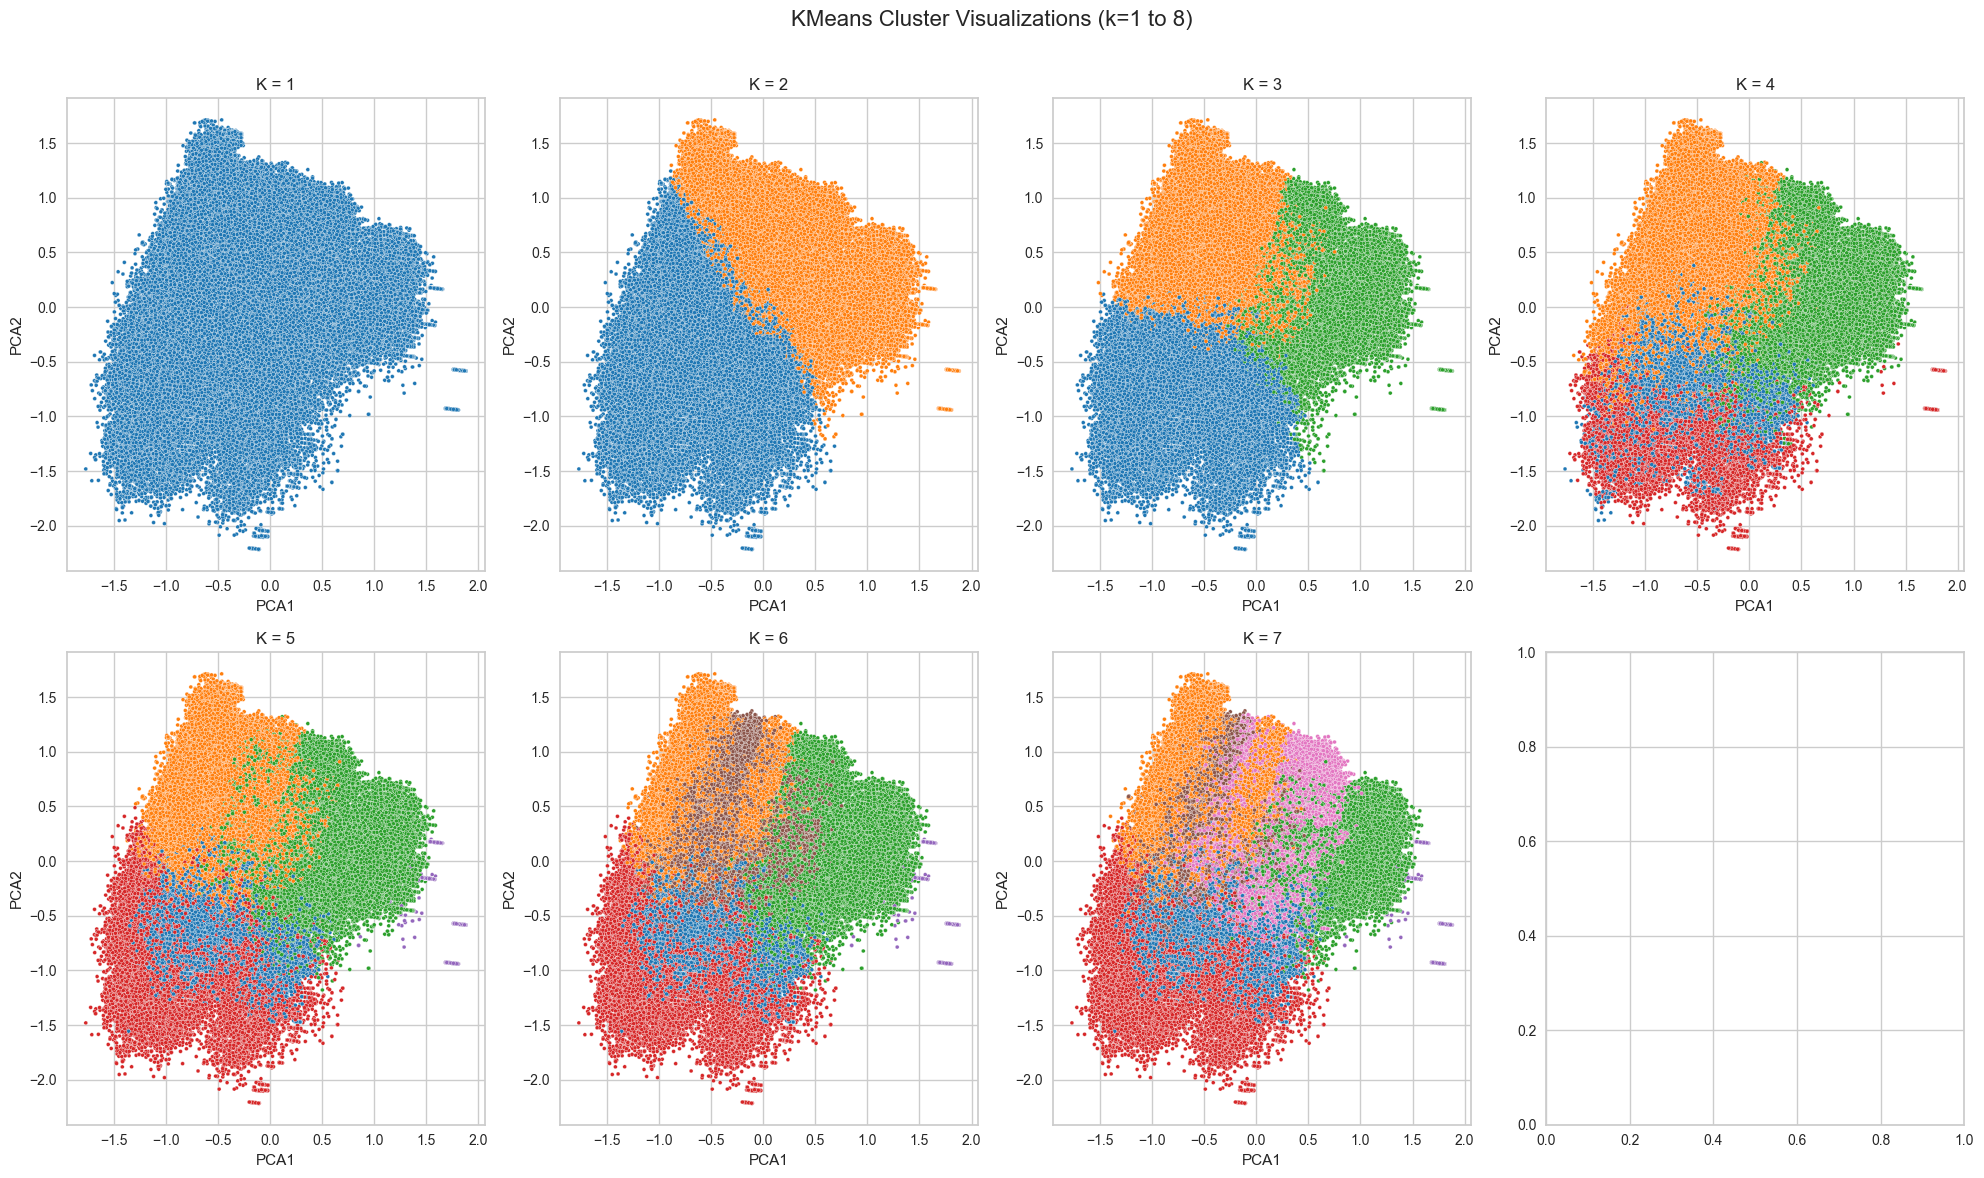

In [ ]:
pca = PCA(n_components=2)


X_pca = pca.fit_transform(X_scaled)

# Set up plotting space
fig, axes = plt.subplots(2, 4, figsize=(20, 12))
axes = axes.flatten()

# Run KMeans for k=1 to 14 and plot 3d results
for i, k in enumerate(range(1, 9)):
    kmeans = KMeans(n_clusters=k, random_state=0)
    labels = kmeans.fit_predict(X_scaled)

    sns.scatterplot(
        x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, 
        palette='tab10', ax=axes[i], legend=False, s=8
    )
    axes[i].set_title(f'K = {k}')
    axes[i].set_xlabel('PCA1')
    axes[i].set_ylabel('PCA2')


plt.suptitle('KMeans Cluster Visualizations (k=1 to 8)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [ ]:
  # You can adjust this based on your data/analysis

clusterer = hdbscan.HDBSCAN(min_cluster_size=40000, cluster_selection_epsilon=0.1)
cluster_labels = clusterer.fit_predict(X_scaled)

# Add cluster labels to the dataframe
df['attack_cluster'] = cluster_labels

# Print cluster sizes
print("Cluster sizes:")
print(pd.Series(cluster_labels).value_counts().sort_index())
pca_vis = PCA(n_components=2)
X_vis = pca_vis.fit_transform(X_scaled)

c:\Users\lucch\Desktop\thesis\thesis\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\lucch\Desktop\thesis\thesis\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Cluster sizes:
-1    170309
 0     18988
 1     10703
Name: count, dtype: int64


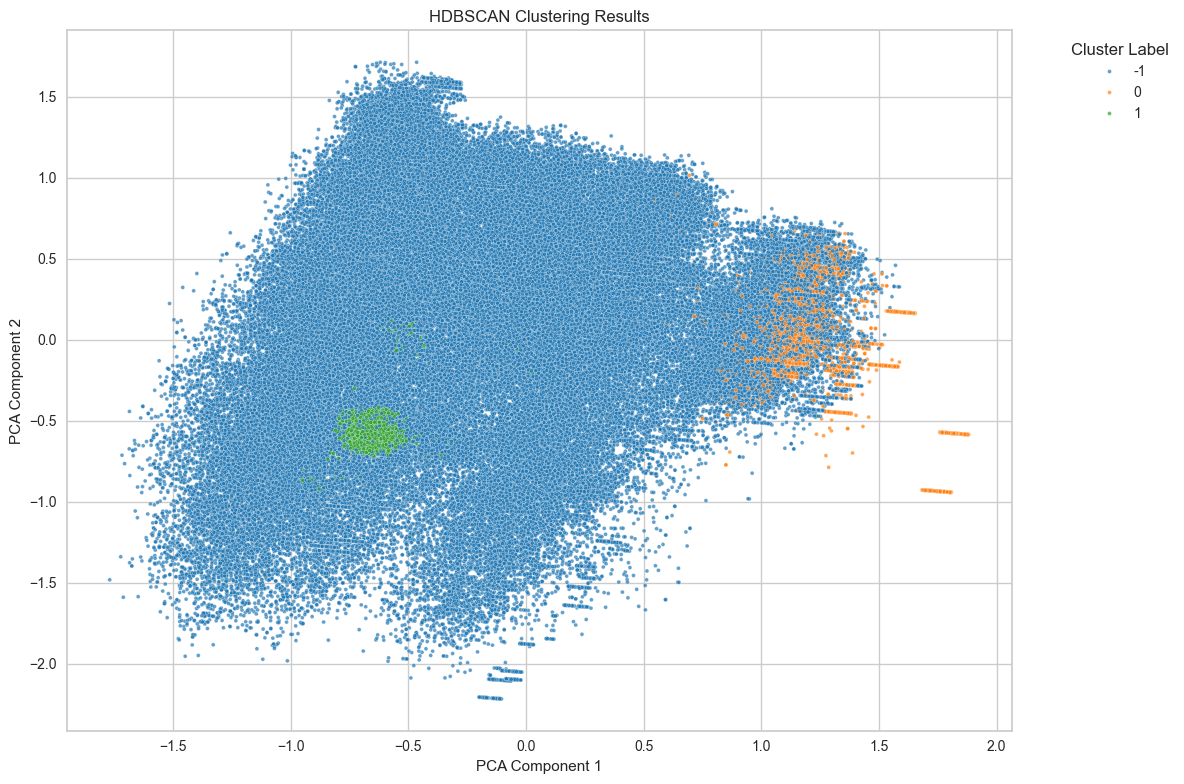

In [14]:
# Plot with noise
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=X_vis[:, 0], y=X_vis[:, 1], hue=cluster_labels, 
    palette='tab10', s=8, legend='full', alpha=0.7
)
plt.title('HDBSCAN Clustering Results')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

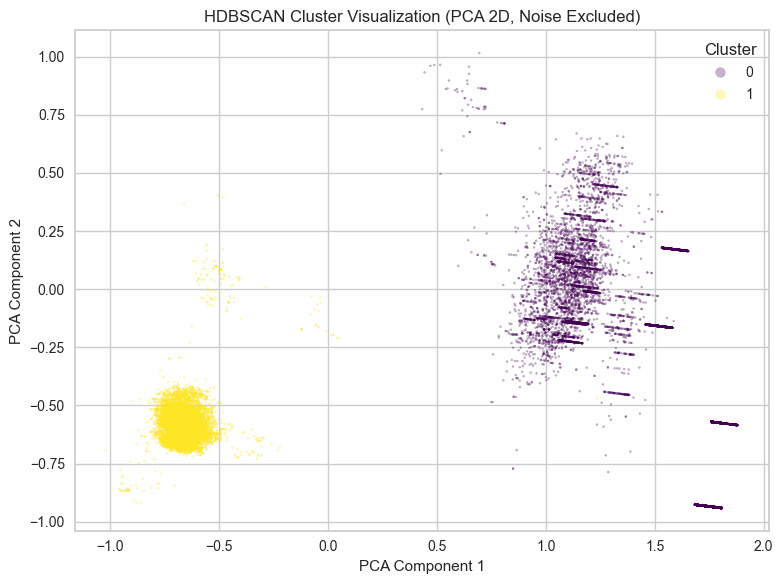

In [11]:
mask = cluster_labels != -1
X_vis_filtered = X_vis[mask]
cluster_labels_filtered = cluster_labels[mask]

# Plot without noise
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_vis_filtered[:, 0], X_vis_filtered[:, 1],
    c=cluster_labels_filtered, cmap='viridis', alpha=0.3, s=2
)
plt.title("HDBSCAN Cluster Visualization (PCA 2D, Noise Excluded)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.tight_layout()
plt.show()

## Clustering Analysis

Apply clustering algorithms and analyze results:
- DBSCAN clustering
- Cluster visualization
- Pattern analysis by cluster
- Geographic and temporal distribution of clusters

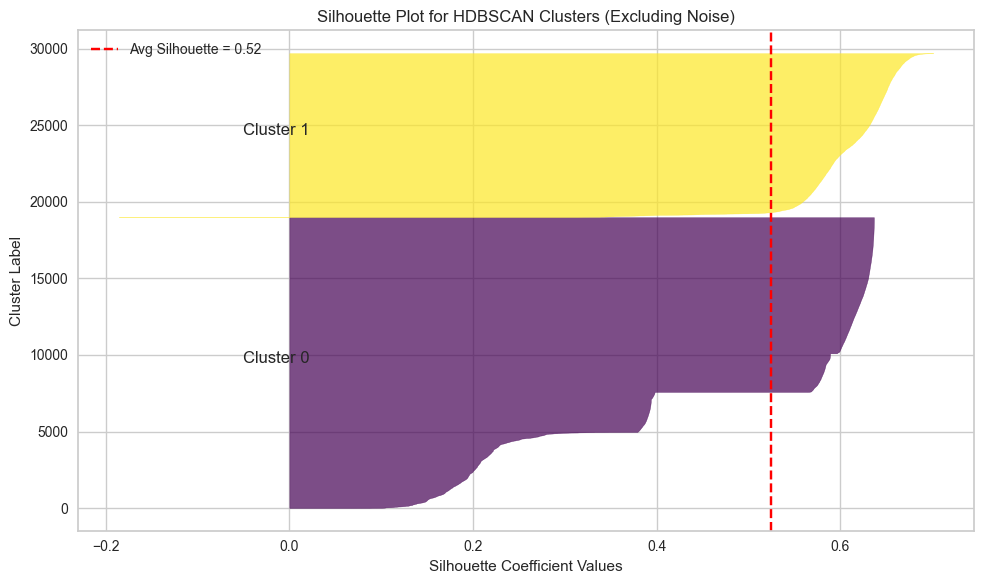

In [15]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Filter out noise (label == -1)
mask = cluster_labels != -1
X_filtered = X_scaled[mask]
labels_filtered = cluster_labels[mask]

# Compute silhouette scores
silhouette_vals = silhouette_samples(X_filtered, labels_filtered)
avg_silhouette = silhouette_score(X_filtered, labels_filtered)

# Sort for better visualization
sorted_idx = np.argsort(labels_filtered)
sorted_silhouette_vals = silhouette_vals[sorted_idx]
sorted_cluster_labels = labels_filtered[sorted_idx]

# Create silhouette plot
fig, ax = plt.subplots(figsize=(10, 6))
y_lower = 10
unique_labels = np.unique(labels_filtered)

for label in unique_labels:
    label_sil_vals = sorted_silhouette_vals[sorted_cluster_labels == label]
    label_sil_vals.sort()
    y_upper = y_lower + len(label_sil_vals)

    color = plt.cm.viridis(float(label) / (len(unique_labels) - 1))
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, label_sil_vals, facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * len(label_sil_vals), f'Cluster {label}')
    y_lower = y_upper + 10

# Draw average silhouette score line
ax.axvline(avg_silhouette, color="red", linestyle="--", label=f"Avg Silhouette = {avg_silhouette:.2f}")
ax.set_title("Silhouette Plot for HDBSCAN Clusters (Excluding Noise)")
ax.set_xlabel("Silhouette Coefficient Values")
ax.set_ylabel("Cluster Label")
ax.legend()
plt.tight_layout()
plt.show()


# Regrouped dataset in same attack timing + src and dst ip experimentation

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score as sil_, calinski_harabasz_score as calinski_
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm
import re
from datetime import datetime, timezone
from sklearn.preprocessing import OneHotEncoder
import ipaddress
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from collections import Counter
import plotly.express as px
from sklearn.utils import resample
import hdbscan
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer


In [38]:
df = pd.read_csv('omnipot_processed.csv')
# df = resample(df, n_samples=200000)
df.reset_index(drop=True, inplace=True)


In [39]:
print(list(df.columns))

['src_port', 'dst_port', 'timestamp', 'src_as', 'src_city', 'src_country', 'src_countryCode', 'src_ip', 'src_proxy', 'src_regionName', 'dst_as', 'dst_city', 'dst_country', 'dst_countryCode', 'dst_ip', 'dst_proxy', 'dst_regionName', 'src_oct1', 'src_oct2', 'src_oct3', 'src_oct4', 'dst_oct1', 'dst_oct2', 'dst_oct3', 'dst_oct4', 'src_lat', 'src_lon', 'src_lat_sin', 'src_lat_cos', 'src_lon_sin', 'src_lon_cos', 'dst_lat', 'dst_lon', 'dst_lat_sin', 'dst_lat_cos', 'dst_lon_sin', 'dst_lon_cos', 'src_timezone', 'dst_timezone', 'src_local_time', 'dst_local_time', 'dst_local_hour', 'src_local_hour', 'hour', 'day_of_week', 'is_weekend', 'max_consecutive_similar', 'sequential_ports', 'port_range', 'port_std', 'attack_entropy', 'target_country_diversity', 'target_city_diversity', 'country_attack_concentration', 'pl_length', 'pl_unique_bytes', 'pl_entropy', 'pl_mean_byte', 'pl_std_byte', 'protocol_category_email', 'protocol_category_file_transfer', 'protocol_category_iot', 'protocol_category_messagin

In [40]:
df.replace({True: 1, False: 0}, inplace=True)

C:\Users\lucch\AppData\Local\Temp\ipykernel_2412\3673826116.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0}, inplace=True)


In [41]:
num_unique_as = df['src_as'].nunique()
as_freq = df['src_as'].value_counts().to_dict()
df['src_as_encoded'] = df['src_as'].map(as_freq)
num_unique_as  

6533

In [42]:
as_freq = df['src_as'].value_counts().to_dict()
df['src_as_encoded'] = df['src_as'].map(as_freq)

In [43]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed', errors='coerce')

df['minute'] = df['timestamp'].dt.minute
df["second"] = df['timestamp'].dt.second

In [44]:
df.drop(columns=["protocol_category", 'src_local_hour', 'dst_local_hour', "timestamp", "src_local_time", "dst_local_time", 'src_ip', 'dst_ip', "src_as", "dst_as", "src_city", "dst_city", "src_country", "dst_country", "src_timezone", "dst_timezone", "src_regionName", "dst_regionName", "src_countryCode", "dst_countryCode", "protocol"], inplace=True, errors='ignore')

In [45]:
df

src_port  dst_port  src_proxy  dst_proxy  src_oct1  src_oct2  \
0          64787       445          0          0       102        43   
1          59105        23          0          0       175       143   
2          13652        22          0          1       184       105   
3          64010       445          0          0       102        43   
4          59105        23          0          0       175       143   
...          ...       ...        ...        ...       ...       ...   
965085     20720        23          0          0       222       138   
965086     20769        23          0          0       222       138   
965087     20811        23          0          0       222       138   
965088     54818        23          0          0       103        77   
965089     20871        23          0          0       222       138   

        src_oct3  src_oct4  dst_oct1  dst_oct2  ...  dst_country_emb_3  \
0             79       235        45        32  ...           0.027427   
1            203       217       158       247  ...          -0.092252   
2            247       252       216       238  ...          -0.280525   
3             79       235        45        32  ...           0.027427   
4            203       217       158       247  ...          -0.092252   
...          ...       ...       ...       ...  ...                ...   
965085       169        59        95       179  ...           0.564470   
965086       169        59        95       179  ...           0.564470   
965087       169        59        95       179  ...           0.564470   
965088       246       172        95       179  ...           0.362980   
965089       169        59        95       179  ...           0.564470   

        dst_country_emb_4  dst_country_emb_5  dst_country_emb_6  \
0               -0.539864          -0.034557          -0.066450   
1               -0.190191           0.080505           0.292334   
2                0.023905           0.005411           0.135804   
3               -0.539864          -0.034557          -0.066450   
4               -0.190191           0.080505           0.292334   
...                   ...                ...                ...   
965085          -0.058352          -0.024158          -0.205507   
965086          -0.058352          -0.024158          -0.205507   
965087          -0.058352          -0.024158          -0.205507   
965088          -0.007916           0.172874           0.195121   
965089          -0.058352          -0.024158          -0.205507   

        dst_country_emb_7  dst_country_emb_8  dst_country_emb_9  \
0               -0.061035           0.287969          -0.014737   
1                0.300746          -0.175745           0.038374   
2                0.017061           0.092698           0.133974   
3               -0.061035           0.287969          -0.014737   
4                0.300746          -0.175745           0.038374   
...                   ...                ...                ...   
965085          -0.007393          -0.205448           0.133934   
965086          -0.007393          -0.205448           0.133934   
965087          -0.007393          -0.205448           0.133934   
965088          -0.060025           0.085136          -0.382583   
965089          -0.007393          -0.205448           0.133934   

        src_as_encoded  minute  second  
0               5124.0       1      59  
1                788.0       0      52  
2               9230.0      32      11  
3               5124.0       1      56  
4                788.0       0      52  
...                ...     ...     ...  
965085         11739.0      59       3  
965086         11739.0      59      16  
965087         11739.0      59      30  
965088           722.0      59      33  
965089         11739.0      59      43  

[965090 rows x 125 columns]

In [ ]:
TIME_THRESHOLD = 300  

# 1. Create IP string representations
df["src_ip_str"] = df["src_oct1"].astype(str) + "." + df["src_oct2"].astype(str) + "." + df["src_oct3"].astype(str) + "." + df["src_oct4"].astype(str)
df["dst_ip_str"] = df["dst_oct1"].astype(str) + "." + df["dst_oct2"].astype(str) + "." + df["dst_oct3"].astype(str) + "." + df["dst_oct4"].astype(str)

# 2. Compute time in seconds
df["hour"] = df["hour"].fillna(0).astype(int)
df["minute"] = df["minute"].fillna(0).astype(int)
df["second"] = df["second"].fillna(0).astype(int)
df["time_seconds"] = df["hour"] * 3600 + df["minute"] * 60 + df["second"]

# 3. Assign burst_id per IP pair
def assign_burst_ids(group):
    group = group.sort_values("time_seconds")
    time_diff = group["time_seconds"].diff().fillna(0)
    burst_start = (time_diff > TIME_THRESHOLD).astype(int)
    group["burst_id"] = burst_start.cumsum()
    return group

df = df.groupby(["src_ip_str", "dst_ip_str"], group_keys=False).apply(assign_burst_ids)

# 4. Group and aggregate
group_cols = ["src_ip_str", "dst_ip_str", "burst_id"]

embedding_cols = [f"src_city_emb_{i}" for i in range(26)] + \
                 [f"dst_city_emb_{i}" for i in range(19)] + \
                 [f"src_country_emb_{i}" for i in range(19)] + \
                 [f"dst_country_emb_{i}" for i in range(10)]

agg_dict = {
    "time_seconds": ["min", "max"],
    "hour": "first", "minute": "first", "second": "first",

    "src_oct1": "first", "src_oct2": "first", "src_oct3": "first", "src_oct4": "first",
    "dst_oct1": "first", "dst_oct2": "first", "dst_oct3": "first", "dst_oct4": "first",

    "src_lat": "first", "src_lon": "first", "dst_lat": "first", "dst_lon": "first",
    "src_lat_sin": "first", "src_lat_cos": "first",
    "src_lon_sin": "first", "src_lon_cos": "first",
    "dst_lat_sin": "first", "dst_lat_cos": "first",
    "dst_lon_sin": "first", "dst_lon_cos": "first",

    "src_proxy": "first", "dst_proxy": "first",
    "sequential_ports": "max",
    "attack_entropy": "mean",
    "is_weekend": "first",
    "dst_port": pd.Series.nunique,

    "protocol_category_email": "first",
    "protocol_category_file_transfer": "first",
    "protocol_category_iot": "first",
    "protocol_category_messaging": "first",
    "protocol_category_remote_access": "first",
    "protocol_category_web": "first",

    "pl_entropy": ["min", "max", "mean"],
    "pl_length": ["sum", "mean"],
    "src_as_encoded": "first",
}

for col in embedding_cols:
    agg_dict[col] = "first"

grouped_df = df.groupby(group_cols).agg(agg_dict)
grouped_df.columns = ['_'.join(col).strip('_') for col in grouped_df.columns.to_flat_index()]
grouped_df = grouped_df.reset_index()

# 5. Compute additional burst statistics
grouped_df["burst_duration"] = grouped_df["time_seconds_max"] - grouped_df["time_seconds_min"]
attack_counts = df.groupby(group_cols).size().reset_index(name="attacks_in_burst")
grouped_df = pd.merge(grouped_df, attack_counts, on=group_cols)
grouped_df["attack_rate"] = grouped_df["attacks_in_burst"] / (grouped_df["burst_duration"] + 1)

print(f"Original attacks: {len(df)}")
print(f"Number of bursts: {len(grouped_df)}")
print("\nSample of grouped bursts:")
print(grouped_df.head())

C:\Users\lucch\AppData\Local\Temp\ipykernel_2412\2305287172.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(["src_ip_str", "dst_ip_str"], group_keys=False).apply(assign_burst_ids)


Original attacks: 965090
Number of bursts: 355814

Sample of grouped bursts:
    src_ip_str      dst_ip_str  burst_id  time_seconds_min  time_seconds_max  \
0  1.0.104.204   139.84.199.23         0             37407             37407   
1  1.0.104.204     45.77.3.100         0             58010             58010   
2  1.0.138.115  139.84.173.144         0             18350             18353   
3    1.0.152.1   67.219.106.34         0             55896             55896   
4    1.0.155.6   141.164.37.80         0             29705             29705   

   hour_first  minute_first  second_first  src_oct1_first  src_oct2_first  \
0          10            23            27               1               0   
1          16             6            50               1               0   
2           5             5            50               1               0   
3          15            31            36               1               0   
4           8            15             5               1

In [54]:
grouped_df["burst_duration"].describe()

count    355814.000000
mean         19.958731
std         195.111546
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max       51616.000000
Name: burst_duration, dtype: float64

# Payload Exploration

This section handles the initial exploration of payload data in hex format:
- Basic payload structure analysis
- Hex data patterns
- Initial feature extraction from hex data

Note: The payloads are currently in 4KB hex format and will be processed without decoding.

# payload analysis TODO later

In [ ]:
import binascii
from collections import Counter

# Function to analyze hex payload without decoding
def analyze_payload(hex_data):
    if pd.isnull(hex_data):
        return {
            'byte_entropy': 0,
            'unique_bytes': 0,
            'max_byte_freq': 0,
            'ascii_ratio': 0,
            'null_ratio': 0,
            'payload_length': 0
        }
    
    try:
        # Work directly with hex string pairs
        # Each byte is represented by 2 hex characters
        hex_pairs = [hex_data[i:i+2] for i in range(0, len(hex_data), 2)]
        total_bytes = len(hex_pairs)
        
        if total_bytes == 0:
            return {
                'byte_entropy': 0,
                'unique_bytes': 0,
                'max_byte_freq': 0,
                'ascii_ratio': 0,
                'null_ratio': 0,
                'payload_length': 0
            }
        
        # Count byte frequencies using hex pairs
        byte_counts = Counter(hex_pairs)
        
        # Calculate byte entropy
        byte_probs = [count/total_bytes for count in byte_counts.values()]
        byte_entropy = -sum(p * np.log2(p) for p in byte_probs)
        
        # Count ASCII and null bytes by looking at hex values
        ascii_bytes = sum(1 for pair in hex_pairs 
                         if 20 <= int(pair, 16) <= 7E)  # 20-7E is printable ASCII
        null_bytes = byte_counts.get('00', 0)
        
        return {
            'byte_entropy': byte_entropy,
            'unique_bytes': len(byte_counts),
            'max_byte_freq': max(byte_counts.values()) / total_bytes,
            'ascii_ratio': ascii_bytes / total_bytes,
            'null_ratio': null_bytes / total_bytes,
            'payload_length': total_bytes
        }
    
    except (ValueError, Exception) as e:
        # Handle invalid hex strings or other errors
        return {
            'byte_entropy': 0,
            'unique_bytes': 0,
            'max_byte_freq': 0,
            'ascii_ratio': 0,
            'null_ratio': 0,
            'payload_length': 0
        }

# Extract payload features
payload_features = pd.DataFrame(df['payload_4kb_hex'].apply(analyze_payload).tolist())

# Add features to main dataframe
for col in payload_features.columns:
    df[f'payload_{col}'] = payload_features[col]

# Print payload feature statistics
print("\nPayload Feature Statistics:")
print(payload_features.describe())

# Visualize payload features
plt.figure(figsize=(15, 5))

# Byte entropy distribution
plt.subplot(131)
plt.hist(df['payload_byte_entropy'].dropna(), bins=50)
plt.title('Payload Byte Entropy Distribution')
plt.xlabel('Byte Entropy')

# ASCII ratio distribution
plt.subplot(132)
plt.hist(df['payload_ascii_ratio'].dropna(), bins=50)
plt.title('ASCII Content Ratio Distribution')
plt.xlabel('ASCII Ratio')

# Payload length distribution
plt.subplot(133)
plt.hist(df['payload_length'].dropna(), bins=50)
plt.title('Payload Length Distribution')
plt.xlabel('Length (bytes)')

plt.tight_layout()
plt.show()

Row 0:
b'\x00\x00\x00\xef\xbf\xbd\xef\xbf\xbdSMBr\x00\x00\x00\x00\x18S\xef\xbf\xbd\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xef\xbf\xbd\xef\xbf\xbd\x00\x00@\x00\x00b\x00\x02PC NETWORK PROGRAM 1.0\x00\x02LANMAN1.0\x00\x02Windows for Workgroups 3.1a\x00\x02LM1.2X002\x00\x02LANMAN2.1\x00\x02NT LM 0.12\x00'

Row 1:
No hex data in the first row.

Row 2:
b'GET / HTTP/1.1\r\nHost: 216.238.89.44:22\r\nUser-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChrome/101.0.4951.41 Safari/537.36\r\nAccept: */*\r\nAccept-Encoding: gzip\r\n\r\n'

Row 3:
b'\x00\x00\x00T\xef\xbf\xbdSMBr\x00\x00\x00\x00\x18\x01(\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00/K\x00\x00\xef\xbf\xbd^\x001\x00\x02LANMAN1.0\x00\x02LM1.2X002\x00\x02NT LANMAN 1.0\x00\x02NT LM 0.12\x00'

Row 4:
No hex data in the first row.

Row 5:
b'GET / HTTP/1.1\r\nHost: 104.238.179.29:22\r\nUser-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) 

In [ ]:

# Visualize payload feature distributions
plt.figure(figsize=(15, 5))

# Entropy vs Payload Length
plt.subplot(131)
plt.scatter(df['payload_byte_entropy'], df['payload_length'], alpha=0.5)
plt.xlabel('Byte Entropy')
plt.ylabel('Payload Length')
plt.title('Entropy vs Length')

# ASCII Ratio Distribution
plt.subplot(132)
plt.hist(df['payload_ascii_ratio'], bins=50)
plt.xlabel('ASCII Ratio')
plt.ylabel('Count')
plt.title('ASCII Content Distribution')

# Unique Bytes vs Length
plt.subplot(133)
plt.scatter(df['payload_unique_bytes'], df['payload_length'], alpha=0.5)
plt.xlabel('Unique Bytes')
plt.ylabel('Payload Length')
plt.title('Byte Diversity vs Length')

plt.tight_layout()

# Payload Analysis

Analyze the 4KB hex payloads to extract useful features:
- Byte frequency distributions
- Common patterns and signatures
- Payload structure analysis
- Protocol-specific patterns

In [ ]:
import codecs
import pandas as pd
import binascii

# Initialize decoder
hex_decoder = codecs.getdecoder("hex_codec")

# Store decoded payloads
decoded_payloads = []

# Loop through your DataFrame rows
for index, row in df.head(13).iterrows():
    hex_data = row.get("payload_4kb_hex")
    
    if pd.notnull(hex_data):
        try:
            # First decode hex to bytes
            decoded_bytes = hex_decoder(hex_data)[0]
            
            # Try UTF-8 first
            try:
                decoded_text = decoded_bytes.decode("utf-8")
            except UnicodeDecodeError:
                # Fall back to Latin-1
                decoded_text = decoded_bytes.decode("latin1")
            
            # Print and store decoded result
            print(f"Row {index}:\n{decoded_text}\n")
            decoded_payloads.append(decoded_text)

        except (UnicodeDecodeError, binascii.Error) as e:
            print(f"Row {index}: Binary or malformed hex - {e}\n")
            decoded_payloads.append("[BINARY DATA]")
        except Exception as e:
            print(f"Row {index}: Unexpected error - {e}\n")
            decoded_payloads.append("[DECODING ERROR]")
    
    else:
        print(f"Row {index}: No hex data.\n")
        decoded_payloads.append("[EMPTY]")


Row 0:
   ��SMBr    S�              ��  @  b PC NETWORK PROGRAM 1.0 LANMAN1.0 Windows for Workgroups 3.1a LM1.2X002 LANMAN2.1 NT LM 0.12 

Row 1: No hex data.

Row 2:
GET / HTTP/1.1
Host: 216.238.89.44:22
User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChrome/101.0.4951.41 Safari/537.36
Accept: */*
Accept-Encoding: gzip



Row 3:
   T�SMBr    (              /K  �^ 1 LANMAN1.0 LM1.2X002 NT LANMAN 1.0 NT LM 0.12 

Row 4: No hex data.

Row 5:
GET / HTTP/1.1
Host: 104.238.179.29:22
User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36
Accept: */*
Accept-Encoding: gzip



Row 6: No hex data.

Row 7: No hex data.

Row 8: No hex data.

Row 9:
  �\��
��g������
![-!	��Jm��@{�O �)�|�'L� (�a�
4��.{*4� &�+�/�,�0̨̩�	��
� � � / 5� 
  �      cf.06151953.xyz       
 
  �      +  3 & $   X.;���+-�mR�t�!�J�0�/�2�0̷Q�N


In [ ]:
import codecs
import pandas as pd

hex_decoder = codecs.getdecoder("hex_codec")

decoded_payloads = []  # store results here

for index, row in df.head(13).iterrows():
    hex_data = row["payload_4kb_hex"]
    if pd.notnull(hex_data):
        try:
            decoded_bytes = hex_decoder(hex_data)[0]
            decoded_text = decoded_bytes.decode("utf-8")
            print(f"Row {index}:\n{decoded_text}\n")
            decoded_payloads.append(decoded_text)

        except UnicodeDecodeError:
            print(f"Row {index}: Binary or non-UTF-8 data\n")
            decoded_payloads.append("[BINARY DATA]")
        except Exception as e:
            print(f"Row {index}: Error decoding - {e}\n")
            decoded_payloads.append("[DECODING ERROR]")
    else:
        print(f"Row {index}: No hex data.\n")
        decoded_payloads.append("[EMPTY]")

Row 0:
   ��SMBr    S�              ��  @  b PC NETWORK PROGRAM 1.0 LANMAN1.0 Windows for Workgroups 3.1a LM1.2X002 LANMAN2.1 NT LM 0.12 

Row 1: No hex data.

Row 2:
GET / HTTP/1.1
Host: 216.238.89.44:22
User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) HeadlessChrome/101.0.4951.41 Safari/537.36
Accept: */*
Accept-Encoding: gzip



Row 3:
   T�SMBr    (              /K  �^ 1 LANMAN1.0 LM1.2X002 NT LANMAN 1.0 NT LM 0.12 

Row 4: No hex data.

Row 5:
GET / HTTP/1.1
Host: 104.238.179.29:22
User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36
Accept: */*
Accept-Encoding: gzip



Row 6: No hex data.

Row 7: No hex data.

Row 8: No hex data.

Row 9:
  �\��
��g������
![-!	��Jm��@{�O �)�|�'L� (�a�
4��.{*4� &�+�/�,�0̨̩�	��
� � � / 5� 
  �      cf.06151953.xyz       
 
  �      +  3 & $   X.;���+-�mR�t�!�J�0�/�2�0̷Q�N
